# IMPORTS

In [1]:
import os
import re
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from accelerate import Accelerator, notebook_launcher
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'hsd-random'
epochs = 10
batch_size = 64
sequence_length = 80

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/multi-label-hate-speech/re_dataset.csv', encoding='latin-1')

alay_dict = pd.read_csv('/kaggle/input/multi-label-hate-speech/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

print("Shape: ", data.shape)
data.head()

Shape:  (13169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [7]:
data.HS.value_counts()

HS
0    7608
1    5561
Name: count, dtype: int64

In [8]:
data.Abusive.value_counts()

Abusive
0    8126
1    5043
Name: count, dtype: int64

In [9]:
print("Toxic shape: ", data[(data['HS'] == 1) | (data['Abusive'] == 1)].shape)
print("Non-toxic shape: ", data[(data['HS'] == 0) & (data['Abusive'] == 0)].shape)

Toxic shape:  (7309, 13)
Non-toxic shape:  (5860, 13)


In [10]:
print("Shape: ", alay_dict.shape)
alay_dict.head(15)

Shape:  (15167, 2)


,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
5,aamiin,amin
6,aamiinn,amin
7,aamin,amin
8,aammiin,amin
9,abis,habis


In [11]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('url', ' ', text) # Remove every URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub(r'\b(?:x[a-fA-F0-9]{2}\s*)+\b', '', text) # Remove emoji bytecode
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

print("remove_nonaplhanumeric: ", remove_nonaplhanumeric("Halooo,,,,, duniaa \x8f \xd2\1 !!"))
print("lowercase: ", lowercase("Halooo, duniaa!"))
print("remove_unnecessary_char: ", remove_unnecessary_char("Hehe\n\n RT USER USER apa kabs www.google.com\n  hehe URL xf8 x2a x89"))
print("normalize_alay: ", normalize_alay("aamiin adek abis"))

remove_nonaplhanumeric:  Halooo duniaa 
lowercase:  halooo, duniaa!
remove_unnecessary_char:  Hehe RT USER USER apa kabs hehe URL 
normalize_alay:  amin adik habis


In [12]:
def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text) 

    return text

In [13]:
data['Tweet'] = data['Tweet'].apply(preprocess)

# Define the labels columns for multi-label classification
label_columns = data.columns[1:]  # Assuming label columns start from the third column

train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

# Extract features and labels for training and validation
X_train = train_data['Tweet'].values
y_train = train_data[label_columns].values
X_val = val_data['Tweet'].values
y_val = val_data[label_columns].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(10535,) (10535, 12)
(2634,) (2634, 12)


# BUILD DATASET & DATALOADERS

In [14]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float if self.use_float else torch.long)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [15]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=96, num_workers=4):
    train_dataset = HateSpeechDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = HateSpeechDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [16]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [17]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong'],
        zero_division=0
    )   
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [18]:
def train_model(current_train_size, train_indices, metrics, trials, seed):
    set_seed(seed)
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(label_columns),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")

            nearest_cp = current_train_size
            if nearest_cp not in checkpoints:
                for cp in checkpoints:
                    if cp > current_train_size:
                        nearest_cp = cp
                        break
            percentage = math.ceil(nearest_cp / total_data * 100)
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials + 1}-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"\n Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [19]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [20]:
def random_sampling(current_train_size, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, n_samples=min_increment):
    start_time = time.time()
    
    nearest_cp = 0
    arrived_at_cp = False
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break

    num_of_candidates = math.ceil(0.1 * len(remaining_indices))

    if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
        num_of_candidates = n_samples
    elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
        num_of_candidates = max(n_samples, num_of_candidates)
    else:
        num_of_candidates = nearest_cp - current_train_size
        arrived_at_cp = True

    random_indices = random.sample(range(len(X_pool)), num_of_candidates)

    if arrived_at_cp:
        temp = train_indices.copy()
        temp.extend([remaining_indices[i] for i in random_indices])
            
        # Save acquired data up to checkpoint
        acquired_data = pd.DataFrame({
            'processed_text': [X_train[i] for i in temp],
            'HS': [y_train[i][0] for i in temp],
            'Abusive': [y_train[i][1] for i in temp],
            'HS_Individual': [y_train[i][2] for i in temp],
            'HS_Group': [y_train[i][3] for i in temp],
            'HS_Religion': [y_train[i][4] for i in temp],
            'HS_Race': [y_train[i][5] for i in temp],
            'HS_Physical': [y_train[i][6] for i in temp],
            'HS_Gender': [y_train[i][7] for i in temp],
            'HS_Other': [y_train[i][8] for i in temp],
            'HS_Weak': [y_train[i][9] for i in temp],
            'HS_Moderate': [y_train[i][10] for i in temp],
            'HS_Strong': [y_train[i][11] for i in temp],
        })

        acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

    end_time = time.time() 
    duration = end_time - start_time

    sampling_dur.append(duration)
    for i in random_indices:
        new_samples.append(remaining_indices[i])
        
    print("Nearest checkpoint:", nearest_cp)
    print("Acquired samples:", len(random_indices))
    print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [21]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
        notebook_launcher(train_model, args, num_processes=2)
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        random_sampling(current_train_size, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [22]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6046, Accuracy: 0.8193, F1 Micro: 0.1306, F1 Macro: 0.0476
Epoch 2/10, Train Loss: 0.4611, Accuracy: 0.8278, F1 Micro: 0.0018, F1 Macro: 0.0007
Epoch 3/10, Train Loss: 0.395, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 4/10, Train Loss: 0.3942, Accuracy: 0.828, F1 Micro: 0.0029, F1 Macro: 0.0013
Epoch 5/10, Train Loss: 0.3771, Accuracy: 0.8331, F1 Micro: 0.0672, F1 Macro: 0.0277
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3693, Accuracy: 0.8492, F1 Micro: 0.2596, F1 Macro: 0.0906
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3465, Accuracy: 0.8548, F1 Micro: 0.3235, F1 Macro: 0.1092
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3297, Accuracy: 0.8708, F1 Micro: 0.4854, F1 Macro: 0.2134
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2965, Accuracy: 0.8761, F1 Micro: 0.5481, F1 Macro: 0.2668
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.2714, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5284, Accuracy: 0.8278, F1 Micro: 0.0022, F1 Macro: 0.0009
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3975, Accuracy: 0.8294, F1 Micro: 0.0199, F1 Macro: 0.0089
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3759, Accuracy: 0.8529, F1 Micro: 0.3198, F1 Macro: 0.1052
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3383, Accuracy: 0.8748, F1 Micro: 0.509, F1 Macro: 0.2326
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3077, Accuracy: 0.8798, F1 Micro: 0.5588, F1 Macro: 0.2659
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2736, Accuracy: 0.8879, F1 Micro: 0.6313, F1 Macro: 0.319
Epoch 7/10, Train Loss: 0.2486, Accuracy: 0.889, F1 Micro: 0.6172, F1 Macro: 0.3235
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2188, Accuracy: 0.8945, F1 Micro: 0.6648, F1 Macro: 0.4332
Epoch 9/10, Train Loss: 0.1948, Accuracy: 0.8948, F1 Micro: 0.6558, F1 Macro: 0.4304
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4882, Accuracy: 0.8285, F1 Micro: 0.009, F1 Macro: 0.0041
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3786, Accuracy: 0.8497, F1 Micro: 0.2785, F1 Macro: 0.0949
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3363, Accuracy: 0.8802, F1 Micro: 0.5692, F1 Macro: 0.2656
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2984, Accuracy: 0.8843, F1 Micro: 0.6484, F1 Macro: 0.3217
Epoch 5/10, Train Loss: 0.2653, Accuracy: 0.8937, F1 Micro: 0.6416, F1 Macro: 0.398
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2266, Accuracy: 0.8972, F1 Micro: 0.6577, F1 Macro: 0.4257
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1992, Accuracy: 0.8991, F1 Micro: 0.698, F1 Macro: 0.5105
Epoch 8/10, Train Loss: 0.1737, Accuracy: 0.9008, F1 Micro: 0.6713, F1 Macro: 0.5032
Epoch 9/10, Train Loss: 0.1537, Accuracy: 0.9007, F1 Micro: 0.6968, F1 Macro: 0.513
Epoch 10/10, Train Loss: 0.1302, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.467, Accuracy: 0.84, F1 Micro: 0.1585, F1 Macro: 0.06
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3583, Accuracy: 0.8783, F1 Micro: 0.5499, F1 Macro: 0.2565
Epoch 3/10, Train Loss: 0.3038, Accuracy: 0.881, F1 Micro: 0.5377, F1 Macro: 0.2692
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2593, Accuracy: 0.8972, F1 Micro: 0.6665, F1 Macro: 0.4134
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2186, Accuracy: 0.9014, F1 Micro: 0.7009, F1 Macro: 0.5347
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1836, Accuracy: 0.8992, F1 Micro: 0.7055, F1 Macro: 0.5124
Epoch 7/10, Train Loss: 0.1646, Accuracy: 0.9044, F1 Micro: 0.697, F1 Macro: 0.5335
Epoch 8/10, Train Loss: 0.1404, Accuracy: 0.9046, F1 Micro: 0.6952, F1 Macro: 0.508
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1194, Accuracy: 0.9041, F1 Micro: 0.7236, F1 Macro: 0.5652
Epoch 10/10, Train Loss: 0.1057, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4533, Accuracy: 0.8405, F1 Micro: 0.1673, F1 Macro: 0.0618
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3457, Accuracy: 0.8807, F1 Micro: 0.576, F1 Macro: 0.2726
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2836, Accuracy: 0.8922, F1 Micro: 0.6351, F1 Macro: 0.3662
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2407, Accuracy: 0.9, F1 Micro: 0.7033, F1 Macro: 0.5208
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2112, Accuracy: 0.903, F1 Micro: 0.7133, F1 Macro: 0.5209
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.189, Accuracy: 0.9054, F1 Micro: 0.7207, F1 Macro: 0.5471
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1591, Accuracy: 0.9077, F1 Micro: 0.7233, F1 Macro: 0.5643
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1372, Accuracy: 0.9101, F1 Micro: 0.7295, F1 Macro: 0.5871
Epoch 9/10, Train Loss: 0.1185, Accuracy: 0.911, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4419, Accuracy: 0.8546, F1 Micro: 0.3837, F1 Macro: 0.1163
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3281, Accuracy: 0.8787, F1 Micro: 0.5314, F1 Macro: 0.2568
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2658, Accuracy: 0.8968, F1 Micro: 0.6733, F1 Macro: 0.4259
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2237, Accuracy: 0.9006, F1 Micro: 0.6956, F1 Macro: 0.5384
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1861, Accuracy: 0.9067, F1 Micro: 0.7204, F1 Macro: 0.5252
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.166, Accuracy: 0.9089, F1 Micro: 0.7252, F1 Macro: 0.5689
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1355, Accuracy: 0.9113, F1 Micro: 0.7296, F1 Macro: 0.5575
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1233, Accuracy: 0.9125, F1 Micro: 0.7392, F1 Macro: 0.6065
Epoch 9/10, Train Loss: 0.1051, Accuracy: 0.9135, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4296, Accuracy: 0.852, F1 Micro: 0.3074, F1 Macro: 0.1136
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3175, Accuracy: 0.8902, F1 Micro: 0.6395, F1 Macro: 0.3221
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2549, Accuracy: 0.9002, F1 Micro: 0.6894, F1 Macro: 0.4421
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2169, Accuracy: 0.9066, F1 Micro: 0.7219, F1 Macro: 0.5514
Epoch 5/10, Train Loss: 0.1791, Accuracy: 0.9113, F1 Micro: 0.7191, F1 Macro: 0.5295
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1531, Accuracy: 0.9141, F1 Micro: 0.735, F1 Macro: 0.5756
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1288, Accuracy: 0.913, F1 Micro: 0.7454, F1 Macro: 0.597
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.11, Accuracy: 0.9153, F1 Micro: 0.7489, F1 Macro: 0.6245
Epoch 9/10, Train Loss: 0.0998, Accuracy: 0.9148, F1 Micro: 0.7475, F1 Macro: 0.606
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4239, Accuracy: 0.8631, F1 Micro: 0.4122, F1 Macro: 0.1686
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2969, Accuracy: 0.8903, F1 Micro: 0.6169, F1 Macro: 0.3175
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2349, Accuracy: 0.9044, F1 Micro: 0.6951, F1 Macro: 0.4388
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2058, Accuracy: 0.9108, F1 Micro: 0.7109, F1 Macro: 0.5134
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1754, Accuracy: 0.9126, F1 Micro: 0.7392, F1 Macro: 0.5652
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1379, Accuracy: 0.9142, F1 Micro: 0.7424, F1 Macro: 0.6031
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.126, Accuracy: 0.9171, F1 Micro: 0.7473, F1 Macro: 0.5955
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1031, Accuracy: 0.9164, F1 Micro: 0.7521, F1 Macro: 0.6293
Epoch 9/10, Train Loss: 0.0926, Accuracy: 0.9139, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4195, Accuracy: 0.8715, F1 Micro: 0.4836, F1 Macro: 0.2097
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2903, Accuracy: 0.8936, F1 Micro: 0.6479, F1 Macro: 0.3746
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2355, Accuracy: 0.9003, F1 Micro: 0.7082, F1 Macro: 0.5249
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2036, Accuracy: 0.9127, F1 Micro: 0.7313, F1 Macro: 0.5534
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1667, Accuracy: 0.915, F1 Micro: 0.7408, F1 Macro: 0.5757
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1413, Accuracy: 0.916, F1 Micro: 0.7488, F1 Macro: 0.5995
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.121, Accuracy: 0.9146, F1 Micro: 0.7532, F1 Macro: 0.6098
Epoch 8/10, Train Loss: 0.098, Accuracy: 0.9189, F1 Micro: 0.7517, F1 Macro: 0.6156
Epoch 9/10, Train Loss: 0.0826, Accuracy: 0.9193, F1 Micro: 0.7454, F1 Macro: 0.629
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4147, Accuracy: 0.8764, F1 Micro: 0.5602, F1 Macro: 0.2548
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2912, Accuracy: 0.8948, F1 Micro: 0.6459, F1 Macro: 0.3801
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2381, Accuracy: 0.9044, F1 Micro: 0.6791, F1 Macro: 0.491
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1938, Accuracy: 0.9122, F1 Micro: 0.7186, F1 Macro: 0.5552
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1648, Accuracy: 0.9142, F1 Micro: 0.7469, F1 Macro: 0.6051
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1385, Accuracy: 0.9157, F1 Micro: 0.7539, F1 Macro: 0.6241
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1153, Accuracy: 0.9203, F1 Micro: 0.7617, F1 Macro: 0.636
Epoch 8/10, Train Loss: 0.0987, Accuracy: 0.9199, F1 Micro: 0.7613, F1 Macro: 0.6461
Epoch 9/10, Train Loss: 0.0866, Accuracy: 0.9198, F1 Micro: 0.7579, F1 Macro: 0.6469
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4105, Accuracy: 0.8745, F1 Micro: 0.6115, F1 Macro: 0.2869
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2811, Accuracy: 0.8985, F1 Micro: 0.6692, F1 Macro: 0.4093
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2236, Accuracy: 0.9058, F1 Micro: 0.6931, F1 Macro: 0.5036
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1916, Accuracy: 0.9135, F1 Micro: 0.7347, F1 Macro: 0.5676
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1584, Accuracy: 0.9165, F1 Micro: 0.737, F1 Macro: 0.5843
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1353, Accuracy: 0.9193, F1 Micro: 0.7544, F1 Macro: 0.6215
Epoch 7/10, Train Loss: 0.1112, Accuracy: 0.9168, F1 Micro: 0.754, F1 Macro: 0.6437
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0975, Accuracy: 0.9195, F1 Micro: 0.7568, F1 Macro: 0.631
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0814, Accuracy: 0.9187, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4065, Accuracy: 0.8791, F1 Micro: 0.5767, F1 Macro: 0.2701
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2791, Accuracy: 0.8973, F1 Micro: 0.696, F1 Macro: 0.4884
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2246, Accuracy: 0.9077, F1 Micro: 0.7186, F1 Macro: 0.5396
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1892, Accuracy: 0.9121, F1 Micro: 0.7381, F1 Macro: 0.5618
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1598, Accuracy: 0.916, F1 Micro: 0.7421, F1 Macro: 0.5947
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1348, Accuracy: 0.9136, F1 Micro: 0.749, F1 Macro: 0.6065
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1129, Accuracy: 0.9185, F1 Micro: 0.7596, F1 Macro: 0.6276
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0936, Accuracy: 0.9199, F1 Micro: 0.7615, F1 Macro: 0.6398
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4028, Accuracy: 0.8707, F1 Micro: 0.6254, F1 Macro: 0.3004
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2765, Accuracy: 0.8992, F1 Micro: 0.6701, F1 Macro: 0.4295
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2253, Accuracy: 0.9062, F1 Micro: 0.6825, F1 Macro: 0.4842
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1916, Accuracy: 0.9139, F1 Micro: 0.737, F1 Macro: 0.5765
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1549, Accuracy: 0.9176, F1 Micro: 0.7477, F1 Macro: 0.5933
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.132, Accuracy: 0.9181, F1 Micro: 0.752, F1 Macro: 0.6173
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1076, Accuracy: 0.9194, F1 Micro: 0.7607, F1 Macro: 0.6343
Epoch 8/10, Train Loss: 0.0938, Accuracy: 0.9188, F1 Micro: 0.7589, F1 Macro: 0.6416
Epoch 9/10, Train Loss: 0.0817, Accuracy: 0.9197, F1 Micro: 0.76, F1 Macro: 0.6631
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4015, Accuracy: 0.8808, F1 Micro: 0.5752, F1 Macro: 0.2708
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.273, Accuracy: 0.9004, F1 Micro: 0.7016, F1 Macro: 0.4965
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2205, Accuracy: 0.9081, F1 Micro: 0.712, F1 Macro: 0.4737
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1865, Accuracy: 0.9144, F1 Micro: 0.747, F1 Macro: 0.5927
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1512, Accuracy: 0.9132, F1 Micro: 0.7555, F1 Macro: 0.6055
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1299, Accuracy: 0.92, F1 Micro: 0.7584, F1 Macro: 0.6131
Epoch 7/10, Train Loss: 0.1093, Accuracy: 0.9192, F1 Micro: 0.7581, F1 Macro: 0.6414
Epoch 8/10, Train Loss: 0.0926, Accuracy: 0.9208, F1 Micro: 0.7536, F1 Macro: 0.6362
Epoch 9/10, Train Loss: 0.078, Accuracy: 0.9177, F1 Micro: 0.7566, F1 Macro: 0.6671
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3994, Accuracy: 0.8826, F1 Micro: 0.6111, F1 Macro: 0.294
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2677, Accuracy: 0.8972, F1 Micro: 0.7066, F1 Macro: 0.505
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2185, Accuracy: 0.912, F1 Micro: 0.7217, F1 Macro: 0.524
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1829, Accuracy: 0.9171, F1 Micro: 0.7465, F1 Macro: 0.5759
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1519, Accuracy: 0.9173, F1 Micro: 0.752, F1 Macro: 0.6154
Epoch 6/10, Train Loss: 0.1266, Accuracy: 0.9201, F1 Micro: 0.7502, F1 Macro: 0.6189
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1077, Accuracy: 0.917, F1 Micro: 0.7598, F1 Macro: 0.6674
Epoch 8/10, Train Loss: 0.0934, Accuracy: 0.9214, F1 Micro: 0.753, F1 Macro: 0.6376
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0831, Accuracy: 0.9219, F1 Micro: 0.7661, F1 Macro: 0.6593
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3968, Accuracy: 0.8826, F1 Micro: 0.5871, F1 Macro: 0.2811
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2651, Accuracy: 0.901, F1 Micro: 0.6958, F1 Macro: 0.4713
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2157, Accuracy: 0.9099, F1 Micro: 0.701, F1 Macro: 0.5131
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1804, Accuracy: 0.9178, F1 Micro: 0.7465, F1 Macro: 0.5921
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1487, Accuracy: 0.9182, F1 Micro: 0.7595, F1 Macro: 0.5966
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1277, Accuracy: 0.9182, F1 Micro: 0.7661, F1 Macro: 0.6313
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1057, Accuracy: 0.9202, F1 Micro: 0.7678, F1 Macro: 0.6443
Epoch 8/10, Train Loss: 0.0897, Accuracy: 0.9222, F1 Micro: 0.7669, F1 Macro: 0.6758
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0728, Accuracy: 0.9234, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3907, Accuracy: 0.8843, F1 Micro: 0.5961, F1 Macro: 0.2911
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2597, Accuracy: 0.9048, F1 Micro: 0.688, F1 Macro: 0.4736
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2154, Accuracy: 0.9088, F1 Micro: 0.7388, F1 Macro: 0.5806
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1802, Accuracy: 0.9174, F1 Micro: 0.7502, F1 Macro: 0.5855
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1513, Accuracy: 0.9226, F1 Micro: 0.7667, F1 Macro: 0.636
Epoch 6/10, Train Loss: 0.1253, Accuracy: 0.9212, F1 Micro: 0.7636, F1 Macro: 0.6319
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0976, Accuracy: 0.9182, F1 Micro: 0.7672, F1 Macro: 0.6637
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0883, Accuracy: 0.9191, F1 Micro: 0.769, F1 Macro: 0.6764
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0763, Accuracy: 0.9219, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3927, Accuracy: 0.878, F1 Micro: 0.5269, F1 Macro: 0.2491
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2606, Accuracy: 0.9025, F1 Micro: 0.7061, F1 Macro: 0.4894
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2133, Accuracy: 0.9125, F1 Micro: 0.7432, F1 Macro: 0.5735
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1775, Accuracy: 0.9184, F1 Micro: 0.7445, F1 Macro: 0.595
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1454, Accuracy: 0.9192, F1 Micro: 0.7647, F1 Macro: 0.6402
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1262, Accuracy: 0.9204, F1 Micro: 0.7686, F1 Macro: 0.6403
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1056, Accuracy: 0.9222, F1 Micro: 0.771, F1 Macro: 0.6695
Epoch 8/10, Train Loss: 0.0874, Accuracy: 0.9199, F1 Micro: 0.7668, F1 Macro: 0.6453
Epoch 9/10, Train Loss: 0.0763, Accuracy: 0.9193, F1 Micro: 0.7665, F1 Macro: 0.6787
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.39, Accuracy: 0.8789, F1 Micro: 0.5397, F1 Macro: 0.2586
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2608, Accuracy: 0.9049, F1 Micro: 0.6994, F1 Macro: 0.4603
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2117, Accuracy: 0.9136, F1 Micro: 0.7368, F1 Macro: 0.5436
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1751, Accuracy: 0.9199, F1 Micro: 0.7575, F1 Macro: 0.6007
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1493, Accuracy: 0.9204, F1 Micro: 0.7637, F1 Macro: 0.6381
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1217, Accuracy: 0.9234, F1 Micro: 0.7731, F1 Macro: 0.6541
Epoch 7/10, Train Loss: 0.104, Accuracy: 0.9236, F1 Micro: 0.7727, F1 Macro: 0.6509
Epoch 8/10, Train Loss: 0.0894, Accuracy: 0.9215, F1 Micro: 0.7685, F1 Macro: 0.6716
Epoch 9/10, Train Loss: 0.0722, Accuracy: 0.9215, F1 Micro: 0.7663, F1 Macro: 0.6627
Epoch 10/10, Train Loss: 0.0627, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3895, Accuracy: 0.8846, F1 Micro: 0.623, F1 Macro: 0.3161
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2618, Accuracy: 0.9023, F1 Micro: 0.708, F1 Macro: 0.4863
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.211, Accuracy: 0.9142, F1 Micro: 0.7403, F1 Macro: 0.5619
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1812, Accuracy: 0.9148, F1 Micro: 0.7536, F1 Macro: 0.6079
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1514, Accuracy: 0.9196, F1 Micro: 0.765, F1 Macro: 0.6327
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1201, Accuracy: 0.9239, F1 Micro: 0.7731, F1 Macro: 0.652
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.105, Accuracy: 0.9233, F1 Micro: 0.7733, F1 Macro: 0.6613
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0872, Accuracy: 0.9245, F1 Micro: 0.7764, F1 Macro: 0.6847
Epoch 9/10, Train Loss: 0.0742, Accuracy: 0.9235, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.383, Accuracy: 0.885, F1 Micro: 0.621, F1 Macro: 0.3081
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.255, Accuracy: 0.9045, F1 Micro: 0.7055, F1 Macro: 0.4846
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2097, Accuracy: 0.9147, F1 Micro: 0.7485, F1 Macro: 0.5636
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1703, Accuracy: 0.9207, F1 Micro: 0.7562, F1 Macro: 0.6048
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1427, Accuracy: 0.9165, F1 Micro: 0.7612, F1 Macro: 0.629
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1195, Accuracy: 0.9203, F1 Micro: 0.7691, F1 Macro: 0.6421
Epoch 7/10, Train Loss: 0.1003, Accuracy: 0.9213, F1 Micro: 0.7523, F1 Macro: 0.65
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0879, Accuracy: 0.9219, F1 Micro: 0.773, F1 Macro: 0.6793
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0708, Accuracy: 0.924, F1 Micro: 0.773

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3875, Accuracy: 0.8846, F1 Micro: 0.6006, F1 Macro: 0.295
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2618, Accuracy: 0.905, F1 Micro: 0.6956, F1 Macro: 0.5136
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2109, Accuracy: 0.9126, F1 Micro: 0.7434, F1 Macro: 0.5649
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1703, Accuracy: 0.9192, F1 Micro: 0.7483, F1 Macro: 0.5909
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1495, Accuracy: 0.9203, F1 Micro: 0.7682, F1 Macro: 0.6374
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1212, Accuracy: 0.9207, F1 Micro: 0.7716, F1 Macro: 0.6591
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1029, Accuracy: 0.9239, F1 Micro: 0.7773, F1 Macro: 0.6796
Epoch 8/10, Train Loss: 0.084, Accuracy: 0.9197, F1 Micro: 0.7712, F1 Macro: 0.6768
Epoch 9/10, Train Loss: 0.0749, Accuracy: 0.9223, F1 Micro: 0.773, F1 Macro: 0.6776
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3822, Accuracy: 0.8842, F1 Micro: 0.5834, F1 Macro: 0.2848
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2571, Accuracy: 0.9048, F1 Micro: 0.7065, F1 Macro: 0.5266
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2044, Accuracy: 0.9152, F1 Micro: 0.7469, F1 Macro: 0.5761
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1667, Accuracy: 0.919, F1 Micro: 0.7649, F1 Macro: 0.6103
Epoch 5/10, Train Loss: 0.1407, Accuracy: 0.9217, F1 Micro: 0.7635, F1 Macro: 0.6177
Epoch 6/10, Train Loss: 0.1211, Accuracy: 0.9218, F1 Micro: 0.7632, F1 Macro: 0.6571
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0989, Accuracy: 0.9234, F1 Micro: 0.7718, F1 Macro: 0.6811
Epoch 8/10, Train Loss: 0.0835, Accuracy: 0.9195, F1 Micro: 0.7616, F1 Macro: 0.6746
Epoch 9/10, Train Loss: 0.0714, Accuracy: 0.9229, F1 Micro: 0.7711, F1 Macro: 0.6844
Epoch 10/10, Train Loss: 0.0631, Accuracy: 0.9209, F1 Micro: 0.7698, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3775, Accuracy: 0.8877, F1 Micro: 0.6347, F1 Macro: 0.3236
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2507, Accuracy: 0.9059, F1 Micro: 0.7187, F1 Macro: 0.5162
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2035, Accuracy: 0.914, F1 Micro: 0.7204, F1 Macro: 0.543
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1675, Accuracy: 0.9201, F1 Micro: 0.7635, F1 Macro: 0.6064
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1428, Accuracy: 0.9227, F1 Micro: 0.7657, F1 Macro: 0.6372
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1161, Accuracy: 0.9191, F1 Micro: 0.7685, F1 Macro: 0.6409
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1005, Accuracy: 0.9217, F1 Micro: 0.7757, F1 Macro: 0.6867
Epoch 8/10, Train Loss: 0.0833, Accuracy: 0.9225, F1 Micro: 0.7703, F1 Macro: 0.6809
Epoch 9/10, Train Loss: 0.0761, Accuracy: 0.9214, F1 Micro: 0.7742, F1 Macro: 0.6885
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3805, Accuracy: 0.8803, F1 Micro: 0.549, F1 Macro: 0.2716
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.254, Accuracy: 0.9069, F1 Micro: 0.6958, F1 Macro: 0.497
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2006, Accuracy: 0.9116, F1 Micro: 0.7458, F1 Macro: 0.5716
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1658, Accuracy: 0.9211, F1 Micro: 0.7587, F1 Macro: 0.631
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1394, Accuracy: 0.9195, F1 Micro: 0.7719, F1 Macro: 0.6571
Epoch 6/10, Train Loss: 0.1191, Accuracy: 0.922, F1 Micro: 0.7714, F1 Macro: 0.6638
Epoch 7/10, Train Loss: 0.0989, Accuracy: 0.9231, F1 Micro: 0.7707, F1 Macro: 0.6525
Epoch 8/10, Train Loss: 0.084, Accuracy: 0.9249, F1 Micro: 0.7681, F1 Macro: 0.6775
Epoch 9/10, Train Loss: 0.0733, Accuracy: 0.9219, F1 Micro: 0.771, F1 Macro: 0.6891
Epoch 10/10, Train Loss: 0.0616, Accuracy: 0.9232, F1 Micro: 0.7698, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3763, Accuracy: 0.8871, F1 Micro: 0.6111, F1 Macro: 0.3037
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2479, Accuracy: 0.9028, F1 Micro: 0.7225, F1 Macro: 0.5534
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2015, Accuracy: 0.9143, F1 Micro: 0.7467, F1 Macro: 0.576
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1675, Accuracy: 0.9182, F1 Micro: 0.7607, F1 Macro: 0.6074
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.142, Accuracy: 0.9242, F1 Micro: 0.7714, F1 Macro: 0.6364
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1158, Accuracy: 0.9209, F1 Micro: 0.7726, F1 Macro: 0.6458
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1041, Accuracy: 0.9201, F1 Micro: 0.774, F1 Macro: 0.6732
Epoch 8/10, Train Loss: 0.0826, Accuracy: 0.9216, F1 Micro: 0.7733, F1 Macro: 0.679
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0738, Accuracy: 0.9242, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3745, Accuracy: 0.8861, F1 Micro: 0.589, F1 Macro: 0.2962
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2507, Accuracy: 0.9067, F1 Micro: 0.7032, F1 Macro: 0.5208
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2033, Accuracy: 0.9166, F1 Micro: 0.7428, F1 Macro: 0.5862
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1649, Accuracy: 0.9205, F1 Micro: 0.7603, F1 Macro: 0.5837
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1407, Accuracy: 0.922, F1 Micro: 0.7733, F1 Macro: 0.652
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1195, Accuracy: 0.9233, F1 Micro: 0.7733, F1 Macro: 0.6665
Epoch 7/10, Train Loss: 0.0979, Accuracy: 0.9216, F1 Micro: 0.7638, F1 Macro: 0.6644
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0813, Accuracy: 0.9242, F1 Micro: 0.7742, F1 Macro: 0.6853
Epoch 9/10, Train Loss: 0.0722, Accuracy: 0.9244, F1 Micro: 0.7717, F1 Macro: 0.6905
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3775, Accuracy: 0.8885, F1 Micro: 0.6337, F1 Macro: 0.3269
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2548, Accuracy: 0.9061, F1 Micro: 0.726, F1 Macro: 0.5492
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2022, Accuracy: 0.9144, F1 Micro: 0.7414, F1 Macro: 0.5705
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1682, Accuracy: 0.9209, F1 Micro: 0.7524, F1 Macro: 0.5919
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1373, Accuracy: 0.9238, F1 Micro: 0.7648, F1 Macro: 0.6488
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1209, Accuracy: 0.9227, F1 Micro: 0.7741, F1 Macro: 0.6863
Epoch 7/10, Train Loss: 0.098, Accuracy: 0.9241, F1 Micro: 0.7726, F1 Macro: 0.665
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0822, Accuracy: 0.9238, F1 Micro: 0.7746, F1 Macro: 0.6922
Epoch 9/10, Train Loss: 0.0728, Accuracy: 0.9249, F1 Micro: 0.7741, F1 Macro: 0.7041
Higher 

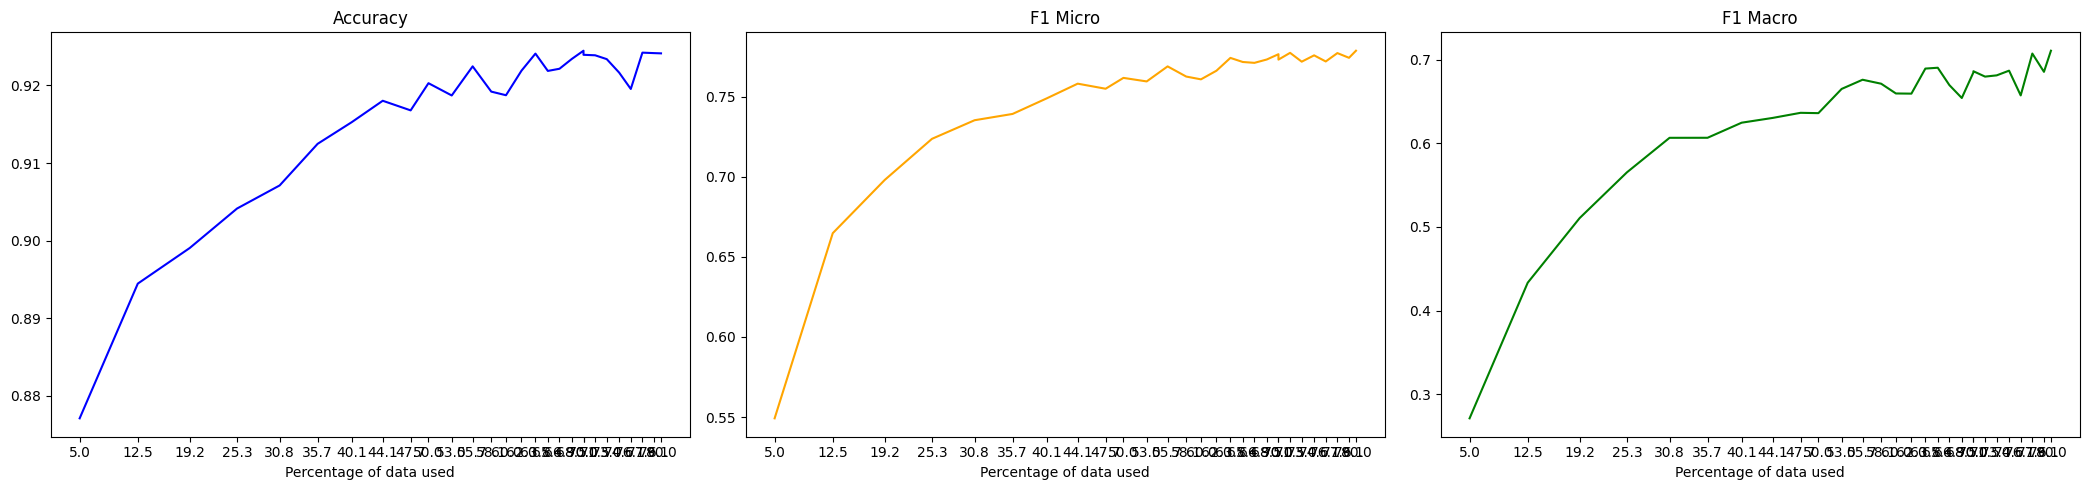

In [ ]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5799, Accuracy: 0.8262, F1 Micro: 0.3921, F1 Macro: 0.1031
Epoch 2/10, Train Loss: 0.4517, Accuracy: 0.8344, F1 Micro: 0.1933, F1 Macro: 0.0512
Epoch 3/10, Train Loss: 0.4051, Accuracy: 0.8316, F1 Micro: 0.068, F1 Macro: 0.0274
Epoch 4/10, Train Loss: 0.3657, Accuracy: 0.8368, F1 Micro: 0.146, F1 Macro: 0.049
Epoch 5/10, Train Loss: 0.3619, Accuracy: 0.8459, F1 Micro: 0.2447, F1 Macro: 0.086
Epoch 6/10, Train Loss: 0.3378, Accuracy: 0.8532, F1 Micro: 0.3418, F1 Macro: 0.1265
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3201, Accuracy: 0.8684, F1 Micro: 0.5, F1 Macro: 0.2319
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3026, Accuracy: 0.8717, F1 Micro: 0.5243, F1 Macro: 0.246
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2623, Accuracy: 0.8734, F1 Micro: 0.5965, F1 Macro: 0.2782
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.2681, Accuracy: 0.875, F1 Micro: 0.6017, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5146, Accuracy: 0.8361, F1 Micro: 0.248, F1 Macro: 0.0568
Epoch 2/10, Train Loss: 0.3996, Accuracy: 0.8373, F1 Micro: 0.1405, F1 Macro: 0.0517
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3569, Accuracy: 0.8619, F1 Micro: 0.4381, F1 Macro: 0.1762
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3218, Accuracy: 0.8788, F1 Micro: 0.578, F1 Macro: 0.2698
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2862, Accuracy: 0.8829, F1 Micro: 0.5946, F1 Macro: 0.2818
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2524, Accuracy: 0.8875, F1 Micro: 0.6286, F1 Macro: 0.3207
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2385, Accuracy: 0.8905, F1 Micro: 0.6513, F1 Macro: 0.3543
Epoch 8/10, Train Loss: 0.2163, Accuracy: 0.8881, F1 Micro: 0.5947, F1 Macro: 0.3443
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1957, Accuracy: 0.8941, F1 Micro: 0.6733, F1 Macro: 0.4523
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4788, Accuracy: 0.832, F1 Micro: 0.0639, F1 Macro: 0.0264
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3698, Accuracy: 0.8584, F1 Micro: 0.3941, F1 Macro: 0.1523
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3198, Accuracy: 0.8827, F1 Micro: 0.5816, F1 Macro: 0.2747
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2761, Accuracy: 0.8894, F1 Micro: 0.6451, F1 Macro: 0.3271
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2419, Accuracy: 0.8938, F1 Micro: 0.6708, F1 Macro: 0.3994
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2147, Accuracy: 0.896, F1 Micro: 0.6914, F1 Macro: 0.4619
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1901, Accuracy: 0.9019, F1 Micro: 0.7003, F1 Macro: 0.5041
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1683, Accuracy: 0.8948, F1 Micro: 0.7069, F1 Macro: 0.5106
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4558, Accuracy: 0.8371, F1 Micro: 0.1344, F1 Macro: 0.0509
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3449, Accuracy: 0.8801, F1 Micro: 0.5825, F1 Macro: 0.2707
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2853, Accuracy: 0.8889, F1 Micro: 0.6133, F1 Macro: 0.3132
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2527, Accuracy: 0.8915, F1 Micro: 0.6813, F1 Macro: 0.4054
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2178, Accuracy: 0.9004, F1 Micro: 0.6938, F1 Macro: 0.4728
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1884, Accuracy: 0.905, F1 Micro: 0.7052, F1 Macro: 0.4914
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1656, Accuracy: 0.9053, F1 Micro: 0.7203, F1 Macro: 0.5297
Epoch 8/10, Train Loss: 0.1389, Accuracy: 0.9082, F1 Micro: 0.7132, F1 Macro: 0.5403
Epoch 9/10, Train Loss: 0.1216, Accuracy: 0.9062, F1 Micro: 0.7151, F1 Macro: 0.534
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.44, Accuracy: 0.8525, F1 Micro: 0.3591, F1 Macro: 0.1121
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3296, Accuracy: 0.8783, F1 Micro: 0.6348, F1 Macro: 0.3077
Epoch 3/10, Train Loss: 0.2772, Accuracy: 0.8935, F1 Micro: 0.6332, F1 Macro: 0.3445
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2369, Accuracy: 0.8986, F1 Micro: 0.6502, F1 Macro: 0.4167
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2097, Accuracy: 0.9035, F1 Micro: 0.7159, F1 Macro: 0.5388
Epoch 6/10, Train Loss: 0.1772, Accuracy: 0.9082, F1 Micro: 0.7052, F1 Macro: 0.5205
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1542, Accuracy: 0.9095, F1 Micro: 0.7307, F1 Macro: 0.5566
Epoch 8/10, Train Loss: 0.1344, Accuracy: 0.91, F1 Micro: 0.7262, F1 Macro: 0.5609
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1125, Accuracy: 0.9085, F1 Micro: 0.739, F1 Macro: 0.594
Epoch 10/10, Train Loss: 0.0987, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4332, Accuracy: 0.8505, F1 Micro: 0.3073, F1 Macro: 0.1034
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3163, Accuracy: 0.886, F1 Micro: 0.6498, F1 Macro: 0.3354
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2592, Accuracy: 0.8975, F1 Micro: 0.6768, F1 Macro: 0.435
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2198, Accuracy: 0.9048, F1 Micro: 0.7155, F1 Macro: 0.5351
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1922, Accuracy: 0.909, F1 Micro: 0.7245, F1 Macro: 0.5188
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1638, Accuracy: 0.9104, F1 Micro: 0.7348, F1 Macro: 0.5686
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1419, Accuracy: 0.9132, F1 Micro: 0.7401, F1 Macro: 0.5785
Epoch 8/10, Train Loss: 0.1205, Accuracy: 0.9133, F1 Micro: 0.7373, F1 Macro: 0.5849
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1022, Accuracy: 0.9152, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4256, Accuracy: 0.8659, F1 Micro: 0.4899, F1 Macro: 0.206
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3041, Accuracy: 0.8909, F1 Micro: 0.6483, F1 Macro: 0.341
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2467, Accuracy: 0.9009, F1 Micro: 0.6745, F1 Macro: 0.4351
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2125, Accuracy: 0.9074, F1 Micro: 0.7247, F1 Macro: 0.5441
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1787, Accuracy: 0.9112, F1 Micro: 0.7338, F1 Macro: 0.5567
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1576, Accuracy: 0.9071, F1 Micro: 0.74, F1 Macro: 0.5749
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1323, Accuracy: 0.9155, F1 Micro: 0.7424, F1 Macro: 0.5952
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1137, Accuracy: 0.9148, F1 Micro: 0.7435, F1 Macro: 0.5914
Epoch 9/10, Train Loss: 0.093, Accuracy: 0.9162, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4131, Accuracy: 0.8696, F1 Micro: 0.486, F1 Macro: 0.2184
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.292, Accuracy: 0.8908, F1 Micro: 0.6054, F1 Macro: 0.3283
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.24, Accuracy: 0.9044, F1 Micro: 0.6951, F1 Macro: 0.4887
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1992, Accuracy: 0.908, F1 Micro: 0.7296, F1 Macro: 0.5347
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1761, Accuracy: 0.9111, F1 Micro: 0.7334, F1 Macro: 0.5378
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1477, Accuracy: 0.9165, F1 Micro: 0.7487, F1 Macro: 0.5941
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1231, Accuracy: 0.9176, F1 Micro: 0.757, F1 Macro: 0.6046
Epoch 8/10, Train Loss: 0.1086, Accuracy: 0.9185, F1 Micro: 0.7547, F1 Macro: 0.6184
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0934, Accuracy: 0.9173, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.409, Accuracy: 0.8645, F1 Micro: 0.415, F1 Macro: 0.1787
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2861, Accuracy: 0.8965, F1 Micro: 0.6714, F1 Macro: 0.4033
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2364, Accuracy: 0.9058, F1 Micro: 0.6894, F1 Macro: 0.4784
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2046, Accuracy: 0.9078, F1 Micro: 0.7401, F1 Macro: 0.5691
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1705, Accuracy: 0.9133, F1 Micro: 0.7461, F1 Macro: 0.5817
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1469, Accuracy: 0.9144, F1 Micro: 0.7501, F1 Macro: 0.5855
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1168, Accuracy: 0.9168, F1 Micro: 0.7549, F1 Macro: 0.6218
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1028, Accuracy: 0.9156, F1 Micro: 0.7579, F1 Macro: 0.6329
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4095, Accuracy: 0.8755, F1 Micro: 0.5481, F1 Macro: 0.2531
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2847, Accuracy: 0.8885, F1 Micro: 0.5828, F1 Macro: 0.3456
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2311, Accuracy: 0.905, F1 Micro: 0.6864, F1 Macro: 0.4785
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1996, Accuracy: 0.912, F1 Micro: 0.7184, F1 Macro: 0.5406
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1647, Accuracy: 0.9149, F1 Micro: 0.7436, F1 Macro: 0.5942
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1396, Accuracy: 0.9176, F1 Micro: 0.7552, F1 Macro: 0.6075
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1187, Accuracy: 0.9141, F1 Micro: 0.758, F1 Macro: 0.6279
Epoch 8/10, Train Loss: 0.1042, Accuracy: 0.917, F1 Micro: 0.7539, F1 Macro: 0.6295
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0884, Accuracy: 0.9173, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4008, Accuracy: 0.8792, F1 Micro: 0.5971, F1 Macro: 0.2795
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.277, Accuracy: 0.8979, F1 Micro: 0.6849, F1 Macro: 0.4192
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2307, Accuracy: 0.909, F1 Micro: 0.7256, F1 Macro: 0.5566
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1925, Accuracy: 0.9138, F1 Micro: 0.7408, F1 Macro: 0.5741
Epoch 5/10, Train Loss: 0.1626, Accuracy: 0.9141, F1 Micro: 0.7341, F1 Macro: 0.5439
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1368, Accuracy: 0.9134, F1 Micro: 0.7569, F1 Macro: 0.6036
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1188, Accuracy: 0.9178, F1 Micro: 0.7591, F1 Macro: 0.6192
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1, Accuracy: 0.9209, F1 Micro: 0.7599, F1 Macro: 0.6379
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0829, Accuracy: 0.9226, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3995, Accuracy: 0.8732, F1 Micro: 0.4846, F1 Macro: 0.2163
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2738, Accuracy: 0.8993, F1 Micro: 0.6891, F1 Macro: 0.4629
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2203, Accuracy: 0.9093, F1 Micro: 0.7038, F1 Macro: 0.5259
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1924, Accuracy: 0.9132, F1 Micro: 0.7442, F1 Macro: 0.5584
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1637, Accuracy: 0.9168, F1 Micro: 0.7593, F1 Macro: 0.6088
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1346, Accuracy: 0.918, F1 Micro: 0.7638, F1 Macro: 0.609
Epoch 7/10, Train Loss: 0.1109, Accuracy: 0.921, F1 Micro: 0.7627, F1 Macro: 0.6362
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0968, Accuracy: 0.9224, F1 Micro: 0.7659, F1 Macro: 0.6483
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0823, Accuracy: 0.9193, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3928, Accuracy: 0.8823, F1 Micro: 0.5789, F1 Macro: 0.2712
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2696, Accuracy: 0.902, F1 Micro: 0.6732, F1 Macro: 0.4617
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2166, Accuracy: 0.9105, F1 Micro: 0.7202, F1 Macro: 0.5446
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1903, Accuracy: 0.9147, F1 Micro: 0.7462, F1 Macro: 0.5681
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1541, Accuracy: 0.9153, F1 Micro: 0.7552, F1 Macro: 0.5966
Epoch 6/10, Train Loss: 0.1358, Accuracy: 0.9209, F1 Micro: 0.7532, F1 Macro: 0.6024
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1116, Accuracy: 0.9198, F1 Micro: 0.7587, F1 Macro: 0.6204
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0994, Accuracy: 0.9215, F1 Micro: 0.7653, F1 Macro: 0.6556
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0817, Accuracy: 0.9211, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3852, Accuracy: 0.8825, F1 Micro: 0.6126, F1 Macro: 0.2946
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2677, Accuracy: 0.9022, F1 Micro: 0.7002, F1 Macro: 0.4973
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2179, Accuracy: 0.9077, F1 Micro: 0.7276, F1 Macro: 0.5268
Epoch 4/10, Train Loss: 0.1856, Accuracy: 0.9132, F1 Micro: 0.717, F1 Macro: 0.5698
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1607, Accuracy: 0.9195, F1 Micro: 0.7574, F1 Macro: 0.5937
Epoch 6/10, Train Loss: 0.1299, Accuracy: 0.9177, F1 Micro: 0.7454, F1 Macro: 0.6011
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1107, Accuracy: 0.9228, F1 Micro: 0.7673, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0954, Accuracy: 0.9222, F1 Micro: 0.7688, F1 Macro: 0.6594
Epoch 9/10, Train Loss: 0.079, Accuracy: 0.9236, F1 Micro: 0.7683, F1 Macro: 0.6557
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3846, Accuracy: 0.8827, F1 Micro: 0.623, F1 Macro: 0.3017
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2646, Accuracy: 0.9013, F1 Micro: 0.6741, F1 Macro: 0.4089
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2175, Accuracy: 0.9119, F1 Micro: 0.7356, F1 Macro: 0.5547
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1848, Accuracy: 0.9173, F1 Micro: 0.749, F1 Macro: 0.582
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1552, Accuracy: 0.9189, F1 Micro: 0.7604, F1 Macro: 0.6054
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1272, Accuracy: 0.9211, F1 Micro: 0.7632, F1 Macro: 0.6409
Epoch 7/10, Train Loss: 0.1077, Accuracy: 0.9221, F1 Micro: 0.7619, F1 Macro: 0.628
Epoch 8/10, Train Loss: 0.0907, Accuracy: 0.9233, F1 Micro: 0.7617, F1 Macro: 0.6476
Epoch 9/10, Train Loss: 0.0776, Accuracy: 0.9235, F1 Micro: 0.7617, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.388, Accuracy: 0.8834, F1 Micro: 0.6072, F1 Macro: 0.296
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2614, Accuracy: 0.9034, F1 Micro: 0.7048, F1 Macro: 0.5091
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2141, Accuracy: 0.9122, F1 Micro: 0.7299, F1 Macro: 0.5539
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1793, Accuracy: 0.9148, F1 Micro: 0.7531, F1 Macro: 0.6029
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.152, Accuracy: 0.9212, F1 Micro: 0.7639, F1 Macro: 0.6132
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1287, Accuracy: 0.9231, F1 Micro: 0.7706, F1 Macro: 0.6441
Epoch 7/10, Train Loss: 0.1061, Accuracy: 0.92, F1 Micro: 0.7619, F1 Macro: 0.6309
Epoch 8/10, Train Loss: 0.093, Accuracy: 0.923, F1 Micro: 0.77, F1 Macro: 0.6498
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0749, Accuracy: 0.9233, F1 Micro: 0.771, F1 Macro: 0.6766
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3844, Accuracy: 0.8832, F1 Micro: 0.6351, F1 Macro: 0.3108
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2643, Accuracy: 0.9027, F1 Micro: 0.6879, F1 Macro: 0.4998
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2138, Accuracy: 0.9112, F1 Micro: 0.7399, F1 Macro: 0.5696
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1817, Accuracy: 0.9207, F1 Micro: 0.7609, F1 Macro: 0.6052
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1498, Accuracy: 0.9184, F1 Micro: 0.7652, F1 Macro: 0.61
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1278, Accuracy: 0.919, F1 Micro: 0.7719, F1 Macro: 0.6622
Epoch 7/10, Train Loss: 0.1109, Accuracy: 0.9201, F1 Micro: 0.7712, F1 Macro: 0.6541
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.091, Accuracy: 0.9241, F1 Micro: 0.7724, F1 Macro: 0.672
Epoch 9/10, Train Loss: 0.0751, Accuracy: 0.9222, F1 Micro: 0.7695, F1 Macro: 0.6629
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3808, Accuracy: 0.8844, F1 Micro: 0.5952, F1 Macro: 0.2897
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2606, Accuracy: 0.9048, F1 Micro: 0.7063, F1 Macro: 0.5046
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2117, Accuracy: 0.9144, F1 Micro: 0.7346, F1 Macro: 0.5361
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1802, Accuracy: 0.9184, F1 Micro: 0.7423, F1 Macro: 0.5885
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1538, Accuracy: 0.9194, F1 Micro: 0.7621, F1 Macro: 0.6174
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1288, Accuracy: 0.9233, F1 Micro: 0.7652, F1 Macro: 0.6451
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1058, Accuracy: 0.9245, F1 Micro: 0.7703, F1 Macro: 0.6697
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0888, Accuracy: 0.9227, F1 Micro: 0.7734, F1 Macro: 0.6642
Epoch 9/10, Train Loss: 0.0765, Accuracy: 0.9233, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3803, Accuracy: 0.8868, F1 Micro: 0.633, F1 Macro: 0.3148
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2584, Accuracy: 0.9054, F1 Micro: 0.7062, F1 Macro: 0.4831
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2098, Accuracy: 0.9164, F1 Micro: 0.7484, F1 Macro: 0.5927
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1705, Accuracy: 0.9186, F1 Micro: 0.7552, F1 Macro: 0.5867
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.146, Accuracy: 0.9203, F1 Micro: 0.769, F1 Macro: 0.631
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1227, Accuracy: 0.9226, F1 Micro: 0.7691, F1 Macro: 0.6447
Epoch 7/10, Train Loss: 0.1036, Accuracy: 0.9234, F1 Micro: 0.7683, F1 Macro: 0.6466
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0866, Accuracy: 0.9221, F1 Micro: 0.7737, F1 Macro: 0.6601
Epoch 9/10, Train Loss: 0.0753, Accuracy: 0.9234, F1 Micro: 0.7733, F1 Macro: 0.6788
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3777, Accuracy: 0.8844, F1 Micro: 0.5886, F1 Macro: 0.2932
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2571, Accuracy: 0.9059, F1 Micro: 0.7024, F1 Macro: 0.4993
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2062, Accuracy: 0.9117, F1 Micro: 0.7288, F1 Macro: 0.5209
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1777, Accuracy: 0.9195, F1 Micro: 0.7675, F1 Macro: 0.6135
Epoch 5/10, Train Loss: 0.1489, Accuracy: 0.9194, F1 Micro: 0.7563, F1 Macro: 0.6229
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1274, Accuracy: 0.9217, F1 Micro: 0.7738, F1 Macro: 0.6353
Epoch 7/10, Train Loss: 0.1031, Accuracy: 0.922, F1 Micro: 0.7711, F1 Macro: 0.6428
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0886, Accuracy: 0.924, F1 Micro: 0.7777, F1 Macro: 0.6802
Epoch 9/10, Train Loss: 0.0766, Accuracy: 0.9226, F1 Micro: 0.7726, F1 Macro: 0.6682
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3795, Accuracy: 0.8865, F1 Micro: 0.651, F1 Macro: 0.3299
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.257, Accuracy: 0.9022, F1 Micro: 0.7143, F1 Macro: 0.5209
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.21, Accuracy: 0.9142, F1 Micro: 0.7333, F1 Macro: 0.5828
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1733, Accuracy: 0.9184, F1 Micro: 0.7497, F1 Macro: 0.5869
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.145, Accuracy: 0.9182, F1 Micro: 0.7688, F1 Macro: 0.6362
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1213, Accuracy: 0.9176, F1 Micro: 0.7693, F1 Macro: 0.6583
Epoch 7/10, Train Loss: 0.1, Accuracy: 0.9215, F1 Micro: 0.7687, F1 Macro: 0.6396
Epoch 8/10, Train Loss: 0.0863, Accuracy: 0.9227, F1 Micro: 0.7673, F1 Macro: 0.6586
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0723, Accuracy: 0.9237, F1 Micro: 0.7781, F1 Macro: 0.6844
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3744, Accuracy: 0.885, F1 Micro: 0.5779, F1 Macro: 0.2872
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.252, Accuracy: 0.9044, F1 Micro: 0.6794, F1 Macro: 0.4541
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.205, Accuracy: 0.9159, F1 Micro: 0.7442, F1 Macro: 0.5763
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1681, Accuracy: 0.9213, F1 Micro: 0.764, F1 Macro: 0.6083
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1462, Accuracy: 0.9221, F1 Micro: 0.7681, F1 Macro: 0.6286
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1216, Accuracy: 0.9223, F1 Micro: 0.7722, F1 Macro: 0.6446
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0992, Accuracy: 0.9238, F1 Micro: 0.7734, F1 Macro: 0.6446
Epoch 8/10, Train Loss: 0.085, Accuracy: 0.9251, F1 Micro: 0.7643, F1 Macro: 0.6595
Epoch 9/10, Train Loss: 0.0715, Accuracy: 0.9232, F1 Micro: 0.7692, F1 Macro: 0.6779
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3745, Accuracy: 0.889, F1 Micro: 0.6383, F1 Macro: 0.3251
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.249, Accuracy: 0.9055, F1 Micro: 0.7221, F1 Macro: 0.5371
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2058, Accuracy: 0.9148, F1 Micro: 0.7384, F1 Macro: 0.5756
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1727, Accuracy: 0.9213, F1 Micro: 0.7557, F1 Macro: 0.5998
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1411, Accuracy: 0.9219, F1 Micro: 0.7699, F1 Macro: 0.6192
Epoch 6/10, Train Loss: 0.1197, Accuracy: 0.9193, F1 Micro: 0.7677, F1 Macro: 0.6434
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1008, Accuracy: 0.9237, F1 Micro: 0.773, F1 Macro: 0.6707
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0867, Accuracy: 0.9269, F1 Micro: 0.7803, F1 Macro: 0.684
Epoch 9/10, Train Loss: 0.0732, Accuracy: 0.9253, F1 Micro: 0.7767, F1 Macro: 0.691
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.374, Accuracy: 0.8872, F1 Micro: 0.6459, F1 Macro: 0.3301
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2522, Accuracy: 0.9064, F1 Micro: 0.6915, F1 Macro: 0.5106
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2079, Accuracy: 0.9166, F1 Micro: 0.7404, F1 Macro: 0.5847
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1684, Accuracy: 0.9217, F1 Micro: 0.7633, F1 Macro: 0.6092
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.145, Accuracy: 0.9212, F1 Micro: 0.7683, F1 Macro: 0.6274
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1259, Accuracy: 0.9231, F1 Micro: 0.7758, F1 Macro: 0.6438
Epoch 7/10, Train Loss: 0.1026, Accuracy: 0.9217, F1 Micro: 0.7699, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0828, Accuracy: 0.9247, F1 Micro: 0.7825, F1 Macro: 0.693
Epoch 9/10, Train Loss: 0.0706, Accuracy: 0.924, F1 Micro: 0.7802, F1 Macro: 0.6805
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3716, Accuracy: 0.8863, F1 Micro: 0.59, F1 Macro: 0.3047
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2521, Accuracy: 0.9065, F1 Micro: 0.7042, F1 Macro: 0.4933
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2043, Accuracy: 0.9175, F1 Micro: 0.7385, F1 Macro: 0.5684
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1693, Accuracy: 0.9212, F1 Micro: 0.7579, F1 Macro: 0.592
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.146, Accuracy: 0.9192, F1 Micro: 0.7587, F1 Macro: 0.5926
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1197, Accuracy: 0.9255, F1 Micro: 0.7728, F1 Macro: 0.6544
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1001, Accuracy: 0.9251, F1 Micro: 0.7798, F1 Macro: 0.6484
Epoch 8/10, Train Loss: 0.0844, Accuracy: 0.9225, F1 Micro: 0.7769, F1 Macro: 0.6853
Epoch 9/10, Train Loss: 0.0698, Accuracy: 0.9198, F1 Micro: 0.7707, F1 Macro: 0.685
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3672, Accuracy: 0.8852, F1 Micro: 0.5729, F1 Macro: 0.291
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2497, Accuracy: 0.9079, F1 Micro: 0.6989, F1 Macro: 0.502
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2004, Accuracy: 0.9169, F1 Micro: 0.7459, F1 Macro: 0.5496
Epoch 4/10, Train Loss: 0.1698, Accuracy: 0.9202, F1 Micro: 0.7443, F1 Macro: 0.5775
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1424, Accuracy: 0.9202, F1 Micro: 0.7682, F1 Macro: 0.6499
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1202, Accuracy: 0.9225, F1 Micro: 0.7752, F1 Macro: 0.6639
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1036, Accuracy: 0.9228, F1 Micro: 0.7785, F1 Macro: 0.6521
Epoch 8/10, Train Loss: 0.0865, Accuracy: 0.9217, F1 Micro: 0.7741, F1 Macro: 0.6651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0724, Accuracy: 0.9255, F1 Micro: 0.7815, F1 Macro: 0.7033
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3671, Accuracy: 0.8911, F1 Micro: 0.6185, F1 Macro: 0.328
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2444, Accuracy: 0.9046, F1 Micro: 0.7248, F1 Macro: 0.525
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2022, Accuracy: 0.9169, F1 Micro: 0.7511, F1 Macro: 0.5867
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1674, Accuracy: 0.9212, F1 Micro: 0.7651, F1 Macro: 0.5975
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1386, Accuracy: 0.9201, F1 Micro: 0.7714, F1 Macro: 0.6356
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1156, Accuracy: 0.9238, F1 Micro: 0.7772, F1 Macro: 0.6659
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0977, Accuracy: 0.9245, F1 Micro: 0.7781, F1 Macro: 0.657
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.083, Accuracy: 0.9262, F1 Micro: 0.7815, F1 Macro: 0.6742
Epoch 9/10, Train Loss: 0.0721, Accuracy: 0.9246, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3684, Accuracy: 0.8895, F1 Micro: 0.615, F1 Macro: 0.3347
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2487, Accuracy: 0.9083, F1 Micro: 0.7143, F1 Macro: 0.5207
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2022, Accuracy: 0.9159, F1 Micro: 0.7327, F1 Macro: 0.5774
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1657, Accuracy: 0.9208, F1 Micro: 0.7681, F1 Macro: 0.6103
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1399, Accuracy: 0.9242, F1 Micro: 0.769, F1 Macro: 0.6329
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1177, Accuracy: 0.9224, F1 Micro: 0.7703, F1 Macro: 0.6392
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.098, Accuracy: 0.9226, F1 Micro: 0.7777, F1 Macro: 0.6756
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0814, Accuracy: 0.9234, F1 Micro: 0.7802, F1 Macro: 0.6939
Epoch 9/10, Train Loss: 0.0703, Accuracy: 0.9248, F1 Micro:

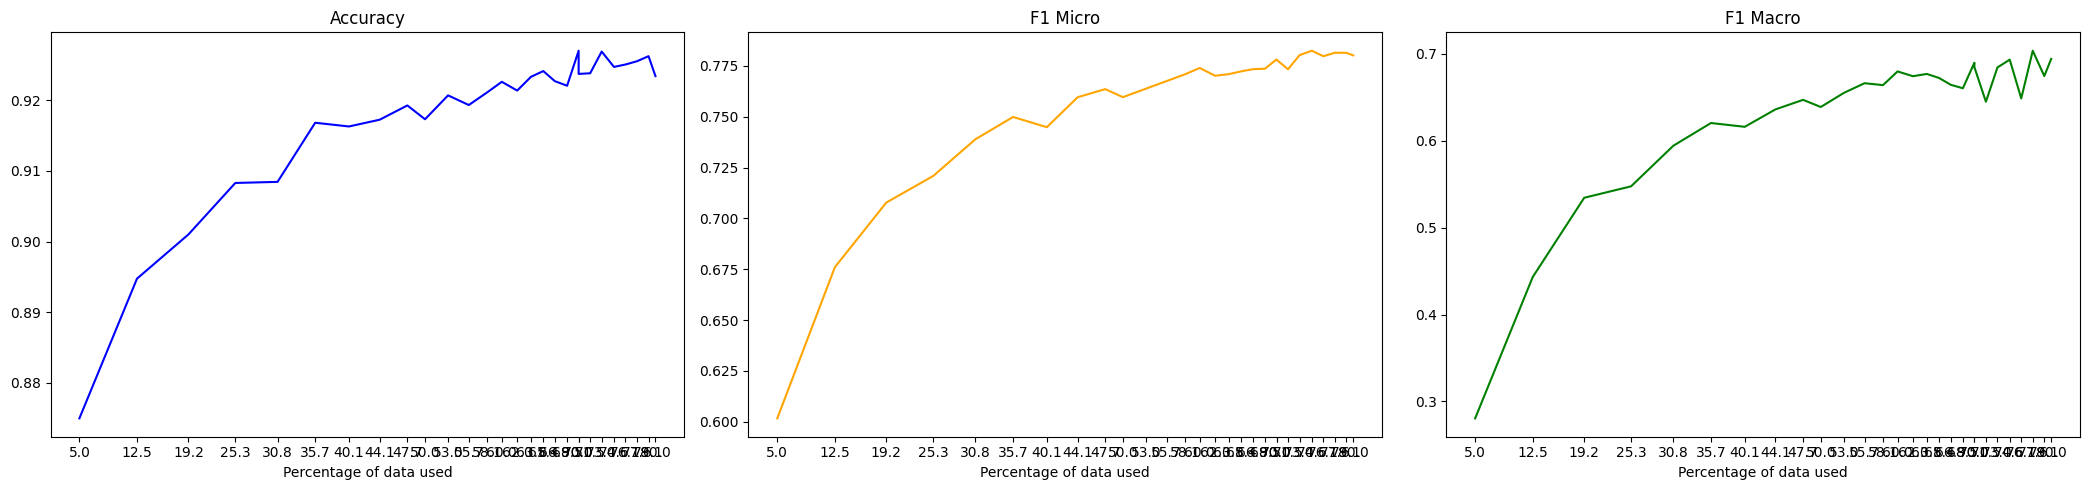

In [ ]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5976, Accuracy: 0.8313, F1 Micro: 0.2023, F1 Macro: 0.0526
Epoch 2/10, Train Loss: 0.4529, Accuracy: 0.8295, F1 Micro: 0.0511, F1 Macro: 0.0184
Epoch 3/10, Train Loss: 0.425, Accuracy: 0.8349, F1 Micro: 0.1135, F1 Macro: 0.0445
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3847, Accuracy: 0.847, F1 Micro: 0.2733, F1 Macro: 0.0921
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.379, Accuracy: 0.8488, F1 Micro: 0.2963, F1 Macro: 0.0979
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3536, Accuracy: 0.8566, F1 Micro: 0.4128, F1 Macro: 0.1411
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.346, Accuracy: 0.8661, F1 Micro: 0.448, F1 Macro: 0.1925
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3125, Accuracy: 0.87, F1 Micro: 0.5757, F1 Macro: 0.2665
Epoch 9/10, Train Loss: 0.3022, Accuracy: 0.8743, F1 Micro: 0.5694, F1 Macro: 0.2653
Epoch 10/10, Train Loss: 0.2677, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5188, Accuracy: 0.8295, F1 Micro: 0.055, F1 Macro: 0.0199
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3996, Accuracy: 0.8389, F1 Micro: 0.1537, F1 Macro: 0.0581
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3693, Accuracy: 0.8589, F1 Micro: 0.4113, F1 Macro: 0.1469
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3297, Accuracy: 0.8755, F1 Micro: 0.5423, F1 Macro: 0.2535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3042, Accuracy: 0.8783, F1 Micro: 0.6109, F1 Macro: 0.2959
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2607, Accuracy: 0.8849, F1 Micro: 0.6139, F1 Macro: 0.3138
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2466, Accuracy: 0.8852, F1 Micro: 0.6614, F1 Macro: 0.3693
Epoch 8/10, Train Loss: 0.2278, Accuracy: 0.8908, F1 Micro: 0.6337, F1 Macro: 0.3746
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2008, Accuracy: 0.8935, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4799, Accuracy: 0.8337, F1 Micro: 0.0964, F1 Macro: 0.038
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3677, Accuracy: 0.8581, F1 Micro: 0.3911, F1 Macro: 0.1454
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3225, Accuracy: 0.8787, F1 Micro: 0.5515, F1 Macro: 0.258
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2824, Accuracy: 0.8867, F1 Micro: 0.6205, F1 Macro: 0.3131
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2498, Accuracy: 0.892, F1 Micro: 0.6736, F1 Macro: 0.4315
Epoch 6/10, Train Loss: 0.2246, Accuracy: 0.8969, F1 Micro: 0.6669, F1 Macro: 0.4427
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1952, Accuracy: 0.899, F1 Micro: 0.6844, F1 Macro: 0.492
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.168, Accuracy: 0.9009, F1 Micro: 0.6861, F1 Macro: 0.4617
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1514, Accuracy: 0.9021, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4527, Accuracy: 0.8447, F1 Micro: 0.2358, F1 Macro: 0.0818
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3504, Accuracy: 0.8764, F1 Micro: 0.5383, F1 Macro: 0.2486
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2978, Accuracy: 0.8872, F1 Micro: 0.6028, F1 Macro: 0.3118
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2532, Accuracy: 0.8965, F1 Micro: 0.6544, F1 Macro: 0.3891
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2209, Accuracy: 0.8994, F1 Micro: 0.6856, F1 Macro: 0.3975
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1941, Accuracy: 0.9044, F1 Micro: 0.6957, F1 Macro: 0.5013
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1731, Accuracy: 0.907, F1 Micro: 0.7006, F1 Macro: 0.5341
Epoch 8/10, Train Loss: 0.1513, Accuracy: 0.9067, F1 Micro: 0.6933, F1 Macro: 0.5296
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1232, Accuracy: 0.9094, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4357, Accuracy: 0.8519, F1 Micro: 0.3591, F1 Macro: 0.1124
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3246, Accuracy: 0.8779, F1 Micro: 0.6161, F1 Macro: 0.2972
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2741, Accuracy: 0.894, F1 Micro: 0.6465, F1 Macro: 0.4067
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2376, Accuracy: 0.9007, F1 Micro: 0.6744, F1 Macro: 0.4411
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2015, Accuracy: 0.9047, F1 Micro: 0.6964, F1 Macro: 0.4759
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1732, Accuracy: 0.9102, F1 Micro: 0.7275, F1 Macro: 0.5332
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1511, Accuracy: 0.9103, F1 Micro: 0.7293, F1 Macro: 0.5713
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1305, Accuracy: 0.909, F1 Micro: 0.7345, F1 Macro: 0.5818
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4314, Accuracy: 0.8522, F1 Micro: 0.3204, F1 Macro: 0.1081
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3181, Accuracy: 0.8852, F1 Micro: 0.6157, F1 Macro: 0.3098
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2628, Accuracy: 0.8976, F1 Micro: 0.659, F1 Macro: 0.4214
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2277, Accuracy: 0.9044, F1 Micro: 0.6983, F1 Macro: 0.5012
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1961, Accuracy: 0.9085, F1 Micro: 0.7201, F1 Macro: 0.5486
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1619, Accuracy: 0.9094, F1 Micro: 0.7299, F1 Macro: 0.5712
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1417, Accuracy: 0.9133, F1 Micro: 0.7346, F1 Macro: 0.5829
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.117, Accuracy: 0.912, F1 Micro: 0.7407, F1 Macro: 0.6131
Epoch 9/10, Train Loss: 0.1004, Accuracy: 0.913, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4248, Accuracy: 0.8596, F1 Micro: 0.3812, F1 Macro: 0.1517
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3038, Accuracy: 0.8913, F1 Micro: 0.6376, F1 Macro: 0.3505
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2486, Accuracy: 0.8995, F1 Micro: 0.6997, F1 Macro: 0.4667
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2097, Accuracy: 0.9075, F1 Micro: 0.7213, F1 Macro: 0.5219
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1775, Accuracy: 0.9124, F1 Micro: 0.7367, F1 Macro: 0.5594
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1495, Accuracy: 0.9143, F1 Micro: 0.7383, F1 Macro: 0.5741
Epoch 7/10, Train Loss: 0.1295, Accuracy: 0.9142, F1 Micro: 0.7377, F1 Macro: 0.5877
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1135, Accuracy: 0.9116, F1 Micro: 0.748, F1 Macro: 0.612
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0931, Accuracy: 0.9128, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4146, Accuracy: 0.8634, F1 Micro: 0.3943, F1 Macro: 0.167
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2921, Accuracy: 0.8863, F1 Micro: 0.5755, F1 Macro: 0.2998
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2413, Accuracy: 0.9025, F1 Micro: 0.6761, F1 Macro: 0.4851
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2051, Accuracy: 0.9112, F1 Micro: 0.7291, F1 Macro: 0.5468
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1746, Accuracy: 0.9138, F1 Micro: 0.7308, F1 Macro: 0.5741
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1419, Accuracy: 0.9151, F1 Micro: 0.7436, F1 Macro: 0.5782
Epoch 7/10, Train Loss: 0.1276, Accuracy: 0.9143, F1 Micro: 0.7393, F1 Macro: 0.5895
Epoch 8/10, Train Loss: 0.1051, Accuracy: 0.9161, F1 Micro: 0.7436, F1 Macro: 0.6155
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0866, Accuracy: 0.9176, F1 Micro: 0.7535, F1 Macro: 0.626
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4096, Accuracy: 0.8735, F1 Micro: 0.5672, F1 Macro: 0.2647
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2919, Accuracy: 0.8955, F1 Micro: 0.6556, F1 Macro: 0.3585
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2354, Accuracy: 0.9045, F1 Micro: 0.7118, F1 Macro: 0.5008
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1955, Accuracy: 0.9111, F1 Micro: 0.7179, F1 Macro: 0.5288
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1717, Accuracy: 0.9153, F1 Micro: 0.7416, F1 Macro: 0.5842
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1411, Accuracy: 0.9151, F1 Micro: 0.7521, F1 Macro: 0.6108
Epoch 7/10, Train Loss: 0.1225, Accuracy: 0.9174, F1 Micro: 0.7468, F1 Macro: 0.5974
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1001, Accuracy: 0.9164, F1 Micro: 0.7597, F1 Macro: 0.6421
Epoch 9/10, Train Loss: 0.0896, Accuracy: 0.9164, F1 Micro: 0.7585, F1 Macro: 0.6442
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.405, Accuracy: 0.8767, F1 Micro: 0.5619, F1 Macro: 0.2666
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2866, Accuracy: 0.8956, F1 Micro: 0.6653, F1 Macro: 0.4236
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2332, Accuracy: 0.9068, F1 Micro: 0.7053, F1 Macro: 0.4995
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1901, Accuracy: 0.9097, F1 Micro: 0.7408, F1 Macro: 0.5859
Epoch 5/10, Train Loss: 0.1647, Accuracy: 0.9146, F1 Micro: 0.7382, F1 Macro: 0.5864
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1364, Accuracy: 0.9155, F1 Micro: 0.7423, F1 Macro: 0.5994
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1186, Accuracy: 0.9196, F1 Micro: 0.7589, F1 Macro: 0.6348
Epoch 8/10, Train Loss: 0.102, Accuracy: 0.92, F1 Micro: 0.7577, F1 Macro: 0.6367
Epoch 9/10, Train Loss: 0.086, Accuracy: 0.9172, F1 Micro: 0.7473, F1 Macro: 0.6252
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4021, Accuracy: 0.8767, F1 Micro: 0.586, F1 Macro: 0.2813
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2799, Accuracy: 0.8974, F1 Micro: 0.6862, F1 Macro: 0.4498
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2296, Accuracy: 0.9099, F1 Micro: 0.7213, F1 Macro: 0.551
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1956, Accuracy: 0.9142, F1 Micro: 0.7363, F1 Macro: 0.5836
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1651, Accuracy: 0.9167, F1 Micro: 0.7515, F1 Macro: 0.5991
Epoch 6/10, Train Loss: 0.1335, Accuracy: 0.9174, F1 Micro: 0.7401, F1 Macro: 0.5866
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1185, Accuracy: 0.9189, F1 Micro: 0.7531, F1 Macro: 0.6193
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0981, Accuracy: 0.9169, F1 Micro: 0.7562, F1 Macro: 0.6428
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0845, Accuracy: 0.9171, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3943, Accuracy: 0.8779, F1 Micro: 0.595, F1 Macro: 0.2886
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.274, Accuracy: 0.901, F1 Micro: 0.6861, F1 Macro: 0.4361
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2233, Accuracy: 0.9058, F1 Micro: 0.6872, F1 Macro: 0.4828
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1891, Accuracy: 0.9142, F1 Micro: 0.7457, F1 Macro: 0.5885
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1623, Accuracy: 0.9174, F1 Micro: 0.7554, F1 Macro: 0.6008
Epoch 6/10, Train Loss: 0.136, Accuracy: 0.9152, F1 Micro: 0.7548, F1 Macro: 0.6195
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1147, Accuracy: 0.9191, F1 Micro: 0.7614, F1 Macro: 0.6427
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0972, Accuracy: 0.9175, F1 Micro: 0.7624, F1 Macro: 0.6613
Epoch 9/10, Train Loss: 0.0824, Accuracy: 0.9189, F1 Micro: 0.7578, F1 Macro: 0.6595
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3971, Accuracy: 0.8791, F1 Micro: 0.5746, F1 Macro: 0.2746
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2717, Accuracy: 0.9003, F1 Micro: 0.6949, F1 Macro: 0.4419
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2267, Accuracy: 0.9118, F1 Micro: 0.7254, F1 Macro: 0.5308
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.187, Accuracy: 0.9179, F1 Micro: 0.7449, F1 Macro: 0.586
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1561, Accuracy: 0.9159, F1 Micro: 0.7553, F1 Macro: 0.6097
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.138, Accuracy: 0.9176, F1 Micro: 0.7581, F1 Macro: 0.6327
Epoch 7/10, Train Loss: 0.1122, Accuracy: 0.9209, F1 Micro: 0.7566, F1 Macro: 0.6406
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0963, Accuracy: 0.9169, F1 Micro: 0.763, F1 Macro: 0.6639
Epoch 9/10, Train Loss: 0.0855, Accuracy: 0.9188, F1 Micro: 0.7591, F1 Macro: 0.6495
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3889, Accuracy: 0.878, F1 Micro: 0.6121, F1 Macro: 0.3007
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.273, Accuracy: 0.8993, F1 Micro: 0.7, F1 Macro: 0.4779
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2176, Accuracy: 0.9104, F1 Micro: 0.708, F1 Macro: 0.534
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1835, Accuracy: 0.9126, F1 Micro: 0.7473, F1 Macro: 0.5896
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1551, Accuracy: 0.9181, F1 Micro: 0.7651, F1 Macro: 0.6201
Epoch 6/10, Train Loss: 0.126, Accuracy: 0.9178, F1 Micro: 0.7638, F1 Macro: 0.63
Epoch 7/10, Train Loss: 0.1066, Accuracy: 0.9197, F1 Micro: 0.7587, F1 Macro: 0.6311
Epoch 8/10, Train Loss: 0.0928, Accuracy: 0.9208, F1 Micro: 0.7645, F1 Macro: 0.644
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0802, Accuracy: 0.9213, F1 Micro: 0.77, F1 Macro: 0.6675
Epoch 10/10, Train Loss: 0.0693, Accuracy: 0.9207,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3872, Accuracy: 0.8797, F1 Micro: 0.6026, F1 Macro: 0.2944
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2666, Accuracy: 0.9015, F1 Micro: 0.6956, F1 Macro: 0.4855
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2179, Accuracy: 0.9094, F1 Micro: 0.7393, F1 Macro: 0.5573
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.184, Accuracy: 0.9137, F1 Micro: 0.75, F1 Macro: 0.5903
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1537, Accuracy: 0.9194, F1 Micro: 0.7509, F1 Macro: 0.6099
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1295, Accuracy: 0.9177, F1 Micro: 0.7599, F1 Macro: 0.6258
Epoch 7/10, Train Loss: 0.1093, Accuracy: 0.9207, F1 Micro: 0.7595, F1 Macro: 0.6485
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0893, Accuracy: 0.9213, F1 Micro: 0.7681, F1 Macro: 0.6502
Epoch 9/10, Train Loss: 0.0791, Accuracy: 0.9195, F1 Micro: 0.7644, F1 Macro: 0.6596
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3831, Accuracy: 0.8819, F1 Micro: 0.6003, F1 Macro: 0.3009
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2599, Accuracy: 0.9033, F1 Micro: 0.695, F1 Macro: 0.488
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2163, Accuracy: 0.9122, F1 Micro: 0.7346, F1 Macro: 0.5253
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1784, Accuracy: 0.9182, F1 Micro: 0.7388, F1 Macro: 0.5854
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1524, Accuracy: 0.9203, F1 Micro: 0.7547, F1 Macro: 0.5982
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1275, Accuracy: 0.9203, F1 Micro: 0.7666, F1 Macro: 0.6362
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1089, Accuracy: 0.923, F1 Micro: 0.7667, F1 Macro: 0.6539
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0889, Accuracy: 0.9226, F1 Micro: 0.7709, F1 Macro: 0.6651
Epoch 9/10, Train Loss: 0.0808, Accuracy: 0.9198, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3846, Accuracy: 0.8824, F1 Micro: 0.6154, F1 Macro: 0.3103
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2538, Accuracy: 0.9014, F1 Micro: 0.7105, F1 Macro: 0.5035
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2097, Accuracy: 0.9146, F1 Micro: 0.7406, F1 Macro: 0.5587
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1744, Accuracy: 0.9171, F1 Micro: 0.7583, F1 Macro: 0.594
Epoch 5/10, Train Loss: 0.1473, Accuracy: 0.9165, F1 Micro: 0.758, F1 Macro: 0.6066
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1259, Accuracy: 0.9182, F1 Micro: 0.7629, F1 Macro: 0.6443
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1058, Accuracy: 0.9216, F1 Micro: 0.77, F1 Macro: 0.6638
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0899, Accuracy: 0.9206, F1 Micro: 0.7704, F1 Macro: 0.6766
Epoch 9/10, Train Loss: 0.0759, Accuracy: 0.9216, F1 Micro: 0.7695, F1 Macro: 0.667
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3833, Accuracy: 0.8824, F1 Micro: 0.5815, F1 Macro: 0.2805
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2603, Accuracy: 0.903, F1 Micro: 0.7051, F1 Macro: 0.4903
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.212, Accuracy: 0.9152, F1 Micro: 0.7418, F1 Macro: 0.5749
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1774, Accuracy: 0.9173, F1 Micro: 0.7512, F1 Macro: 0.5974
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1479, Accuracy: 0.9197, F1 Micro: 0.7555, F1 Macro: 0.613
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1256, Accuracy: 0.9216, F1 Micro: 0.7656, F1 Macro: 0.6519
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1056, Accuracy: 0.92, F1 Micro: 0.7665, F1 Macro: 0.6658
Epoch 8/10, Train Loss: 0.0891, Accuracy: 0.9227, F1 Micro: 0.7628, F1 Macro: 0.6729
Epoch 9/10, Train Loss: 0.0768, Accuracy: 0.9214, F1 Micro: 0.7657, F1 Macro: 0.678
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3798, Accuracy: 0.8841, F1 Micro: 0.6303, F1 Macro: 0.33
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2552, Accuracy: 0.9037, F1 Micro: 0.6979, F1 Macro: 0.5088
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2105, Accuracy: 0.914, F1 Micro: 0.7377, F1 Macro: 0.5785
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.176, Accuracy: 0.9171, F1 Micro: 0.7566, F1 Macro: 0.596
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1512, Accuracy: 0.9197, F1 Micro: 0.765, F1 Macro: 0.6405
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1254, Accuracy: 0.9154, F1 Micro: 0.7655, F1 Macro: 0.6592
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1025, Accuracy: 0.922, F1 Micro: 0.7674, F1 Macro: 0.6845
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0845, Accuracy: 0.92, F1 Micro: 0.769, F1 Macro: 0.6858
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0762, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3755, Accuracy: 0.8828, F1 Micro: 0.6338, F1 Macro: 0.3362
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.258, Accuracy: 0.9038, F1 Micro: 0.7056, F1 Macro: 0.5307
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2118, Accuracy: 0.9138, F1 Micro: 0.7328, F1 Macro: 0.5787
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1762, Accuracy: 0.9136, F1 Micro: 0.7569, F1 Macro: 0.6037
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1544, Accuracy: 0.922, F1 Micro: 0.768, F1 Macro: 0.6332
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.122, Accuracy: 0.9208, F1 Micro: 0.769, F1 Macro: 0.6577
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1005, Accuracy: 0.9196, F1 Micro: 0.769, F1 Macro: 0.6801
Epoch 8/10, Train Loss: 0.0905, Accuracy: 0.9164, F1 Micro: 0.7637, F1 Macro: 0.6707
Epoch 9/10, Train Loss: 0.0786, Accuracy: 0.9221, F1 Micro: 0.7616, F1 Macro: 0.6686
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.376, Accuracy: 0.8845, F1 Micro: 0.5849, F1 Macro: 0.2906
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.259, Accuracy: 0.9039, F1 Micro: 0.7107, F1 Macro: 0.5048
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2079, Accuracy: 0.9146, F1 Micro: 0.7481, F1 Macro: 0.5881
Epoch 4/10, Train Loss: 0.1741, Accuracy: 0.9163, F1 Micro: 0.7339, F1 Macro: 0.5921
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1445, Accuracy: 0.9204, F1 Micro: 0.7569, F1 Macro: 0.6188
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1223, Accuracy: 0.9212, F1 Micro: 0.7682, F1 Macro: 0.6731
Epoch 7/10, Train Loss: 0.1044, Accuracy: 0.9221, F1 Micro: 0.7676, F1 Macro: 0.6638
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0824, Accuracy: 0.92, F1 Micro: 0.7699, F1 Macro: 0.6798
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0736, Accuracy: 0.9228, F1 Micro: 0.7736, F1 Macro: 0.6729
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3768, Accuracy: 0.8865, F1 Micro: 0.6189, F1 Macro: 0.3183
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.254, Accuracy: 0.9068, F1 Micro: 0.7007, F1 Macro: 0.4771
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2083, Accuracy: 0.9147, F1 Micro: 0.746, F1 Macro: 0.5782
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1764, Accuracy: 0.9126, F1 Micro: 0.7575, F1 Macro: 0.6007
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.148, Accuracy: 0.9213, F1 Micro: 0.7631, F1 Macro: 0.6278
Epoch 6/10, Train Loss: 0.1232, Accuracy: 0.9219, F1 Micro: 0.7605, F1 Macro: 0.6457
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.104, Accuracy: 0.9207, F1 Micro: 0.7692, F1 Macro: 0.6669
Epoch 8/10, Train Loss: 0.0876, Accuracy: 0.9193, F1 Micro: 0.7673, F1 Macro: 0.6795
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.076, Accuracy: 0.9228, F1 Micro: 0.773, F1 Macro: 0.6929
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3722, Accuracy: 0.8875, F1 Micro: 0.6229, F1 Macro: 0.3272
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2521, Accuracy: 0.9058, F1 Micro: 0.6926, F1 Macro: 0.4779
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2056, Accuracy: 0.9152, F1 Micro: 0.7405, F1 Macro: 0.5669
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1714, Accuracy: 0.9197, F1 Micro: 0.7645, F1 Macro: 0.6131
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1428, Accuracy: 0.9223, F1 Micro: 0.7655, F1 Macro: 0.6262
Epoch 6/10, Train Loss: 0.1187, Accuracy: 0.9206, F1 Micro: 0.7645, F1 Macro: 0.6425
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1008, Accuracy: 0.9209, F1 Micro: 0.7682, F1 Macro: 0.6606
Epoch 8/10, Train Loss: 0.0844, Accuracy: 0.9216, F1 Micro: 0.7609, F1 Macro: 0.6701
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.073, Accuracy: 0.9221, F1 Micro: 0.7703, F1 Macro: 0.6937
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3731, Accuracy: 0.8871, F1 Micro: 0.6177, F1 Macro: 0.3231
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2522, Accuracy: 0.9059, F1 Micro: 0.7082, F1 Macro: 0.5259
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2084, Accuracy: 0.9161, F1 Micro: 0.7431, F1 Macro: 0.5738
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1696, Accuracy: 0.92, F1 Micro: 0.7564, F1 Macro: 0.5992
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1434, Accuracy: 0.9165, F1 Micro: 0.7645, F1 Macro: 0.6268
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1223, Accuracy: 0.9235, F1 Micro: 0.7691, F1 Macro: 0.6646
Epoch 7/10, Train Loss: 0.1008, Accuracy: 0.9226, F1 Micro: 0.7646, F1 Macro: 0.6642
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0889, Accuracy: 0.924, F1 Micro: 0.7727, F1 Macro: 0.6782
Epoch 9/10, Train Loss: 0.0718, Accuracy: 0.923, F1 Micro: 0.7694, F1 Macro: 0.685
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3669, Accuracy: 0.8868, F1 Micro: 0.6383, F1 Macro: 0.3408
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2458, Accuracy: 0.9053, F1 Micro: 0.7155, F1 Macro: 0.4979
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2082, Accuracy: 0.913, F1 Micro: 0.7466, F1 Macro: 0.586
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1727, Accuracy: 0.921, F1 Micro: 0.7598, F1 Macro: 0.612
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1451, Accuracy: 0.9217, F1 Micro: 0.7729, F1 Macro: 0.6636
Epoch 6/10, Train Loss: 0.1224, Accuracy: 0.9235, F1 Micro: 0.7667, F1 Macro: 0.6567
Epoch 7/10, Train Loss: 0.1003, Accuracy: 0.9213, F1 Micro: 0.7586, F1 Macro: 0.6528
Epoch 8/10, Train Loss: 0.088, Accuracy: 0.9243, F1 Micro: 0.7691, F1 Macro: 0.6726
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0716, Accuracy: 0.9206, F1 Micro: 0.7739, F1 Macro: 0.6911
Epoch 10/10, Train Loss: 0.062, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3669, Accuracy: 0.885, F1 Micro: 0.6509, F1 Macro: 0.3446
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2486, Accuracy: 0.9053, F1 Micro: 0.6739, F1 Macro: 0.4895
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2075, Accuracy: 0.9152, F1 Micro: 0.7233, F1 Macro: 0.5526
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1744, Accuracy: 0.9204, F1 Micro: 0.7506, F1 Macro: 0.5902
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1435, Accuracy: 0.9234, F1 Micro: 0.7661, F1 Macro: 0.6404
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1237, Accuracy: 0.9218, F1 Micro: 0.7717, F1 Macro: 0.6613
Epoch 7/10, Train Loss: 0.0992, Accuracy: 0.9197, F1 Micro: 0.7698, F1 Macro: 0.6676
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0853, Accuracy: 0.9206, F1 Micro: 0.7726, F1 Macro: 0.6935
Epoch 9/10, Train Loss: 0.0719, Accuracy: 0.9232, F1 Micro: 0.7693, F1 Macro: 0.6874
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3639, Accuracy: 0.8891, F1 Micro: 0.6408, F1 Macro: 0.348
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2473, Accuracy: 0.9049, F1 Micro: 0.6753, F1 Macro: 0.4946
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2003, Accuracy: 0.9172, F1 Micro: 0.7361, F1 Macro: 0.5777
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1725, Accuracy: 0.9198, F1 Micro: 0.7467, F1 Macro: 0.5971
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1396, Accuracy: 0.9231, F1 Micro: 0.7669, F1 Macro: 0.6277
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1215, Accuracy: 0.9221, F1 Micro: 0.7766, F1 Macro: 0.6909
Epoch 7/10, Train Loss: 0.0995, Accuracy: 0.9244, F1 Micro: 0.7759, F1 Macro: 0.6733
Epoch 8/10, Train Loss: 0.0824, Accuracy: 0.9224, F1 Micro: 0.7668, F1 Macro: 0.6877
Epoch 9/10, Train Loss: 0.0703, Accuracy: 0.9215, F1 Micro: 0.7544, F1 Macro: 0.6644
Epoch 10/10, Train Loss: 0.0617, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.364, Accuracy: 0.8891, F1 Micro: 0.6606, F1 Macro: 0.3701
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2426, Accuracy: 0.9048, F1 Micro: 0.7283, F1 Macro: 0.5458
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1999, Accuracy: 0.9175, F1 Micro: 0.7529, F1 Macro: 0.5834
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1626, Accuracy: 0.9218, F1 Micro: 0.763, F1 Macro: 0.6026
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1411, Accuracy: 0.919, F1 Micro: 0.7755, F1 Macro: 0.6631
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1173, Accuracy: 0.924, F1 Micro: 0.7782, F1 Macro: 0.6675
Epoch 7/10, Train Loss: 0.096, Accuracy: 0.924, F1 Micro: 0.7736, F1 Macro: 0.6832
Epoch 8/10, Train Loss: 0.0859, Accuracy: 0.9204, F1 Micro: 0.7733, F1 Macro: 0.6942
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0683, Accuracy: 0.9248, F1 Micro: 0.7819, F1 Macro: 0.6949
Higher F1 

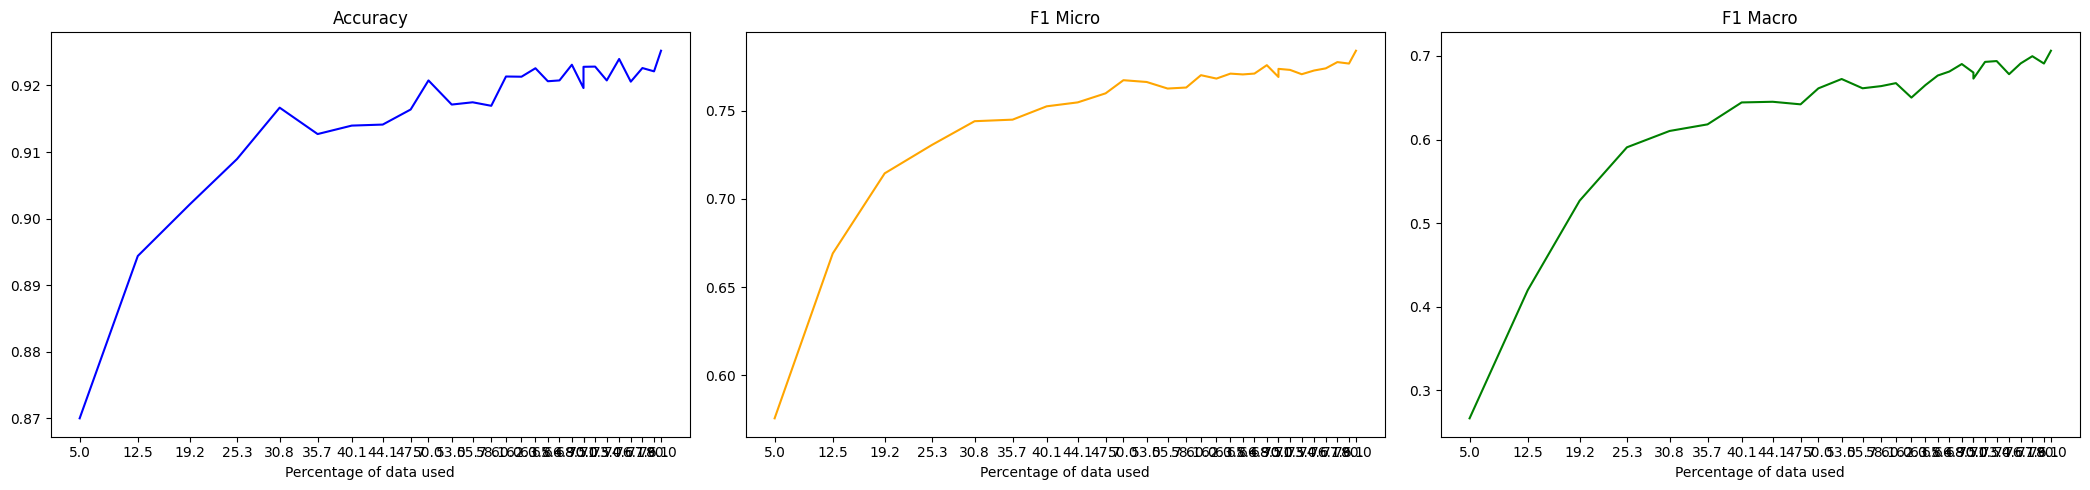

In [25]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6124, Accuracy: 0.8295, F1 Micro: 0.1273, F1 Macro: 0.0425
Epoch 2/10, Train Loss: 0.4669, Accuracy: 0.8283, F1 Micro: 0.0135, F1 Macro: 0.006
Epoch 3/10, Train Loss: 0.4072, Accuracy: 0.8326, F1 Micro: 0.0718, F1 Macro: 0.0278
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3847, Accuracy: 0.838, F1 Micro: 0.1376, F1 Macro: 0.0524
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3789, Accuracy: 0.8464, F1 Micro: 0.2428, F1 Macro: 0.0852
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3643, Accuracy: 0.8568, F1 Micro: 0.3734, F1 Macro: 0.1234
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3388, Accuracy: 0.8677, F1 Micro: 0.4735, F1 Macro: 0.2056
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3082, Accuracy: 0.8719, F1 Micro: 0.5043, F1 Macro: 0.2334
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2915, Accuracy: 0.8765, F1 Micro: 0.545, F1 Macro: 0.2588
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5381, Accuracy: 0.8296, F1 Micro: 0.031, F1 Macro: 0.0132
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.388, Accuracy: 0.8384, F1 Micro: 0.1564, F1 Macro: 0.0556
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3625, Accuracy: 0.8561, F1 Micro: 0.3558, F1 Macro: 0.1278
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3228, Accuracy: 0.8724, F1 Micro: 0.6017, F1 Macro: 0.2779
Epoch 5/10, Train Loss: 0.2994, Accuracy: 0.8819, F1 Micro: 0.5692, F1 Macro: 0.2675
Epoch 6/10, Train Loss: 0.2665, Accuracy: 0.8839, F1 Micro: 0.5794, F1 Macro: 0.2852
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2316, Accuracy: 0.8843, F1 Micro: 0.6424, F1 Macro: 0.3488
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2131, Accuracy: 0.8849, F1 Micro: 0.6593, F1 Macro: 0.4305
Epoch 9/10, Train Loss: 0.1925, Accuracy: 0.8885, F1 Micro: 0.6387, F1 Macro: 0.4324
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4865, Accuracy: 0.8351, F1 Micro: 0.1291, F1 Macro: 0.0426
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.372, Accuracy: 0.8586, F1 Micro: 0.4468, F1 Macro: 0.1712
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3205, Accuracy: 0.8786, F1 Micro: 0.5905, F1 Macro: 0.2765
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.286, Accuracy: 0.8853, F1 Micro: 0.6109, F1 Macro: 0.29
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2472, Accuracy: 0.8907, F1 Micro: 0.6332, F1 Macro: 0.3397
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2216, Accuracy: 0.8912, F1 Micro: 0.6841, F1 Macro: 0.4621
Epoch 7/10, Train Loss: 0.1949, Accuracy: 0.8968, F1 Micro: 0.6556, F1 Macro: 0.4215
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1728, Accuracy: 0.8993, F1 Micro: 0.6965, F1 Macro: 0.5016
Epoch 9/10, Train Loss: 0.1541, Accuracy: 0.9012, F1 Micro: 0.6834, F1 Macro: 0.4897
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4649, Accuracy: 0.835, F1 Micro: 0.1025, F1 Macro: 0.0385
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3515, Accuracy: 0.8756, F1 Micro: 0.5836, F1 Macro: 0.2692
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.294, Accuracy: 0.8857, F1 Micro: 0.6296, F1 Macro: 0.3103
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2596, Accuracy: 0.8895, F1 Micro: 0.683, F1 Macro: 0.4353
Epoch 5/10, Train Loss: 0.2266, Accuracy: 0.8953, F1 Micro: 0.6732, F1 Macro: 0.4088
Epoch 6/10, Train Loss: 0.1875, Accuracy: 0.8996, F1 Micro: 0.6695, F1 Macro: 0.4694
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.168, Accuracy: 0.9033, F1 Micro: 0.7058, F1 Macro: 0.5392
Epoch 8/10, Train Loss: 0.1482, Accuracy: 0.902, F1 Micro: 0.6997, F1 Macro: 0.5327
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1247, Accuracy: 0.9067, F1 Micro: 0.7162, F1 Macro: 0.5504
Epoch 10/10, Train Loss: 0.1127, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4503, Accuracy: 0.846, F1 Micro: 0.2514, F1 Macro: 0.0868
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3344, Accuracy: 0.8801, F1 Micro: 0.5815, F1 Macro: 0.2747
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2771, Accuracy: 0.8912, F1 Micro: 0.652, F1 Macro: 0.3904
Epoch 4/10, Train Loss: 0.2456, Accuracy: 0.8924, F1 Micro: 0.6177, F1 Macro: 0.3799
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2031, Accuracy: 0.9026, F1 Micro: 0.704, F1 Macro: 0.4857
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1819, Accuracy: 0.9053, F1 Micro: 0.7049, F1 Macro: 0.4962
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1515, Accuracy: 0.9038, F1 Micro: 0.7257, F1 Macro: 0.5529
Epoch 8/10, Train Loss: 0.1326, Accuracy: 0.9098, F1 Micro: 0.7238, F1 Macro: 0.5665
Epoch 9/10, Train Loss: 0.1142, Accuracy: 0.9057, F1 Micro: 0.7162, F1 Macro: 0.5709
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4429, Accuracy: 0.8544, F1 Micro: 0.3639, F1 Macro: 0.1144
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3225, Accuracy: 0.8847, F1 Micro: 0.6012, F1 Macro: 0.2952
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2658, Accuracy: 0.8962, F1 Micro: 0.6572, F1 Macro: 0.4296
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2212, Accuracy: 0.9022, F1 Micro: 0.7075, F1 Macro: 0.491
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1931, Accuracy: 0.9039, F1 Micro: 0.7169, F1 Macro: 0.5261
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1687, Accuracy: 0.9098, F1 Micro: 0.7207, F1 Macro: 0.5471
Epoch 7/10, Train Loss: 0.1348, Accuracy: 0.9095, F1 Micro: 0.7081, F1 Macro: 0.5498
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1142, Accuracy: 0.9052, F1 Micro: 0.7282, F1 Macro: 0.5705
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1059, Accuracy: 0.9098, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.428, Accuracy: 0.8611, F1 Micro: 0.408, F1 Macro: 0.1545
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3103, Accuracy: 0.8887, F1 Micro: 0.6378, F1 Macro: 0.3398
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2551, Accuracy: 0.8968, F1 Micro: 0.6914, F1 Macro: 0.4625
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2174, Accuracy: 0.9043, F1 Micro: 0.7092, F1 Macro: 0.4794
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1812, Accuracy: 0.9074, F1 Micro: 0.7258, F1 Macro: 0.5583
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1539, Accuracy: 0.9071, F1 Micro: 0.7354, F1 Macro: 0.5604
Epoch 7/10, Train Loss: 0.1349, Accuracy: 0.9127, F1 Micro: 0.7341, F1 Macro: 0.5778
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1107, Accuracy: 0.9107, F1 Micro: 0.7456, F1 Macro: 0.6203
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0971, Accuracy: 0.9146, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4207, Accuracy: 0.8705, F1 Micro: 0.5077, F1 Macro: 0.2116
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2978, Accuracy: 0.893, F1 Micro: 0.6717, F1 Macro: 0.392
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2463, Accuracy: 0.903, F1 Micro: 0.6869, F1 Macro: 0.4518
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2063, Accuracy: 0.909, F1 Micro: 0.7055, F1 Macro: 0.5169
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.178, Accuracy: 0.9116, F1 Micro: 0.7396, F1 Macro: 0.567
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.145, Accuracy: 0.9109, F1 Micro: 0.7428, F1 Macro: 0.586
Epoch 7/10, Train Loss: 0.1232, Accuracy: 0.9169, F1 Micro: 0.7412, F1 Macro: 0.5991
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1093, Accuracy: 0.9143, F1 Micro: 0.7533, F1 Macro: 0.6275
Epoch 9/10, Train Loss: 0.095, Accuracy: 0.9115, F1 Micro: 0.7382, F1 Macro: 0.6221
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4174, Accuracy: 0.87, F1 Micro: 0.4545, F1 Macro: 0.2022
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2909, Accuracy: 0.8942, F1 Micro: 0.6514, F1 Macro: 0.3833
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2404, Accuracy: 0.9026, F1 Micro: 0.7037, F1 Macro: 0.4701
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2061, Accuracy: 0.9096, F1 Micro: 0.7281, F1 Macro: 0.5144
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1744, Accuracy: 0.9133, F1 Micro: 0.7401, F1 Macro: 0.5536
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1418, Accuracy: 0.916, F1 Micro: 0.7456, F1 Macro: 0.5923
Epoch 7/10, Train Loss: 0.1213, Accuracy: 0.9172, F1 Micro: 0.7415, F1 Macro: 0.618
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1082, Accuracy: 0.9183, F1 Micro: 0.7497, F1 Macro: 0.6221
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.087, Accuracy: 0.9177, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.412, Accuracy: 0.8782, F1 Micro: 0.5824, F1 Macro: 0.2701
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2886, Accuracy: 0.8933, F1 Micro: 0.677, F1 Macro: 0.4101
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2369, Accuracy: 0.9043, F1 Micro: 0.7028, F1 Macro: 0.5045
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2061, Accuracy: 0.9105, F1 Micro: 0.7081, F1 Macro: 0.5254
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1703, Accuracy: 0.9118, F1 Micro: 0.7402, F1 Macro: 0.5711
Epoch 6/10, Train Loss: 0.1407, Accuracy: 0.9144, F1 Micro: 0.7329, F1 Macro: 0.5973
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1194, Accuracy: 0.9147, F1 Micro: 0.7429, F1 Macro: 0.6131
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1032, Accuracy: 0.9209, F1 Micro: 0.7605, F1 Macro: 0.6417
Epoch 9/10, Train Loss: 0.0827, Accuracy: 0.9135, F1 Micro: 0.7557, F1 Macro: 0.6516
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4088, Accuracy: 0.8781, F1 Micro: 0.5814, F1 Macro: 0.2696
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2893, Accuracy: 0.8955, F1 Micro: 0.6764, F1 Macro: 0.4087
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2337, Accuracy: 0.9061, F1 Micro: 0.6948, F1 Macro: 0.4754
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1996, Accuracy: 0.91, F1 Micro: 0.7385, F1 Macro: 0.5501
Epoch 5/10, Train Loss: 0.1686, Accuracy: 0.9154, F1 Micro: 0.7355, F1 Macro: 0.5826
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1405, Accuracy: 0.9156, F1 Micro: 0.7508, F1 Macro: 0.5932
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1145, Accuracy: 0.9164, F1 Micro: 0.757, F1 Macro: 0.644
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0973, Accuracy: 0.9168, F1 Micro: 0.7573, F1 Macro: 0.6637
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0852, Accuracy: 0.9174, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4044, Accuracy: 0.879, F1 Micro: 0.5857, F1 Macro: 0.272
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.282, Accuracy: 0.8977, F1 Micro: 0.6502, F1 Macro: 0.4262
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2294, Accuracy: 0.9055, F1 Micro: 0.7087, F1 Macro: 0.5177
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1959, Accuracy: 0.9128, F1 Micro: 0.7244, F1 Macro: 0.5503
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1644, Accuracy: 0.9154, F1 Micro: 0.75, F1 Macro: 0.6054
Epoch 6/10, Train Loss: 0.1356, Accuracy: 0.9184, F1 Micro: 0.7477, F1 Macro: 0.6109
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1157, Accuracy: 0.9191, F1 Micro: 0.7587, F1 Macro: 0.641
Epoch 8/10, Train Loss: 0.095, Accuracy: 0.9203, F1 Micro: 0.7533, F1 Macro: 0.6482
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0834, Accuracy: 0.9162, F1 Micro: 0.7617, F1 Macro: 0.6754
Higher F1 a

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.402, Accuracy: 0.8783, F1 Micro: 0.6166, F1 Macro: 0.2851
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2783, Accuracy: 0.8962, F1 Micro: 0.6933, F1 Macro: 0.4528
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2306, Accuracy: 0.9089, F1 Micro: 0.7226, F1 Macro: 0.539
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1916, Accuracy: 0.9133, F1 Micro: 0.7409, F1 Macro: 0.5687
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1604, Accuracy: 0.9169, F1 Micro: 0.7585, F1 Macro: 0.6056
Epoch 6/10, Train Loss: 0.1359, Accuracy: 0.9196, F1 Micro: 0.7497, F1 Macro: 0.638
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1122, Accuracy: 0.9186, F1 Micro: 0.7618, F1 Macro: 0.6511
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0997, Accuracy: 0.9172, F1 Micro: 0.7629, F1 Macro: 0.6684
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.084, Accuracy: 0.9183, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3995, Accuracy: 0.8806, F1 Micro: 0.5829, F1 Macro: 0.2724
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2734, Accuracy: 0.899, F1 Micro: 0.6965, F1 Macro: 0.4672
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2238, Accuracy: 0.9059, F1 Micro: 0.7271, F1 Macro: 0.5496
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1855, Accuracy: 0.9134, F1 Micro: 0.7429, F1 Macro: 0.5902
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1567, Accuracy: 0.915, F1 Micro: 0.7558, F1 Macro: 0.6077
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1299, Accuracy: 0.9162, F1 Micro: 0.7628, F1 Macro: 0.6476
Epoch 7/10, Train Loss: 0.111, Accuracy: 0.9201, F1 Micro: 0.7602, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0937, Accuracy: 0.9189, F1 Micro: 0.7629, F1 Macro: 0.672
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0757, Accuracy: 0.9178, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3968, Accuracy: 0.8805, F1 Micro: 0.579, F1 Macro: 0.2685
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2685, Accuracy: 0.901, F1 Micro: 0.6789, F1 Macro: 0.4656
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2202, Accuracy: 0.9104, F1 Micro: 0.7238, F1 Macro: 0.5416
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1826, Accuracy: 0.9141, F1 Micro: 0.742, F1 Macro: 0.5921
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1564, Accuracy: 0.9143, F1 Micro: 0.7591, F1 Macro: 0.6208
Epoch 6/10, Train Loss: 0.1285, Accuracy: 0.9157, F1 Micro: 0.7547, F1 Macro: 0.6224
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1079, Accuracy: 0.9172, F1 Micro: 0.761, F1 Macro: 0.6577
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0947, Accuracy: 0.9203, F1 Micro: 0.7644, F1 Macro: 0.672
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0784, Accuracy: 0.9202, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.391, Accuracy: 0.8799, F1 Micro: 0.6115, F1 Macro: 0.2866
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2658, Accuracy: 0.9022, F1 Micro: 0.6872, F1 Macro: 0.4601
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2123, Accuracy: 0.9093, F1 Micro: 0.7308, F1 Macro: 0.527
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1786, Accuracy: 0.9171, F1 Micro: 0.7481, F1 Macro: 0.5812
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1531, Accuracy: 0.9187, F1 Micro: 0.7544, F1 Macro: 0.6128
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1293, Accuracy: 0.9179, F1 Micro: 0.7673, F1 Macro: 0.6564
Epoch 7/10, Train Loss: 0.1094, Accuracy: 0.9191, F1 Micro: 0.7664, F1 Macro: 0.6669
Epoch 8/10, Train Loss: 0.0902, Accuracy: 0.9179, F1 Micro: 0.7662, F1 Macro: 0.6852
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.076, Accuracy: 0.9198, F1 Micro: 0.7689, F1 Macro: 0.6777
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3869, Accuracy: 0.882, F1 Micro: 0.5934, F1 Macro: 0.276
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2658, Accuracy: 0.9018, F1 Micro: 0.6874, F1 Macro: 0.4452
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2149, Accuracy: 0.9115, F1 Micro: 0.74, F1 Macro: 0.5638
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1816, Accuracy: 0.9153, F1 Micro: 0.749, F1 Macro: 0.5912
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1496, Accuracy: 0.918, F1 Micro: 0.7609, F1 Macro: 0.6205
Epoch 6/10, Train Loss: 0.127, Accuracy: 0.9219, F1 Micro: 0.7592, F1 Macro: 0.621
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1082, Accuracy: 0.9208, F1 Micro: 0.7629, F1 Macro: 0.6693
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0887, Accuracy: 0.918, F1 Micro: 0.7649, F1 Macro: 0.6802
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0756, Accuracy: 0.9234, F1 Micro: 0.767

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3889, Accuracy: 0.8825, F1 Micro: 0.6074, F1 Macro: 0.2871
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2628, Accuracy: 0.9023, F1 Micro: 0.6817, F1 Macro: 0.4788
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2146, Accuracy: 0.911, F1 Micro: 0.7355, F1 Macro: 0.5619
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1792, Accuracy: 0.9186, F1 Micro: 0.7501, F1 Macro: 0.5984
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1517, Accuracy: 0.9207, F1 Micro: 0.7563, F1 Macro: 0.595
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1283, Accuracy: 0.9202, F1 Micro: 0.767, F1 Macro: 0.6692
Epoch 7/10, Train Loss: 0.1056, Accuracy: 0.9218, F1 Micro: 0.7632, F1 Macro: 0.6421
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0911, Accuracy: 0.9219, F1 Micro: 0.7687, F1 Macro: 0.6739
Epoch 9/10, Train Loss: 0.075, Accuracy: 0.9172, F1 Micro: 0.7628, F1 Macro: 0.6749
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3864, Accuracy: 0.8813, F1 Micro: 0.5671, F1 Macro: 0.2631
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2639, Accuracy: 0.9016, F1 Micro: 0.7034, F1 Macro: 0.4883
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2104, Accuracy: 0.9121, F1 Micro: 0.7339, F1 Macro: 0.5605
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1793, Accuracy: 0.9183, F1 Micro: 0.7512, F1 Macro: 0.5878
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1496, Accuracy: 0.9214, F1 Micro: 0.76, F1 Macro: 0.614
Epoch 6/10, Train Loss: 0.1248, Accuracy: 0.9221, F1 Micro: 0.7553, F1 Macro: 0.6179
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1041, Accuracy: 0.921, F1 Micro: 0.7667, F1 Macro: 0.6706
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0903, Accuracy: 0.9214, F1 Micro: 0.7698, F1 Macro: 0.6961
Epoch 9/10, Train Loss: 0.0739, Accuracy: 0.9175, F1 Micro: 0.7662, F1 Macro: 0.6909
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3799, Accuracy: 0.8861, F1 Micro: 0.6131, F1 Macro: 0.2933
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.261, Accuracy: 0.9003, F1 Micro: 0.7122, F1 Macro: 0.4968
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2128, Accuracy: 0.9129, F1 Micro: 0.7194, F1 Macro: 0.5374
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1765, Accuracy: 0.9176, F1 Micro: 0.7614, F1 Macro: 0.6007
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1464, Accuracy: 0.9214, F1 Micro: 0.7718, F1 Macro: 0.6635
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1233, Accuracy: 0.9223, F1 Micro: 0.7742, F1 Macro: 0.6673
Epoch 7/10, Train Loss: 0.1038, Accuracy: 0.9199, F1 Micro: 0.768, F1 Macro: 0.6631
Epoch 8/10, Train Loss: 0.0883, Accuracy: 0.9203, F1 Micro: 0.769, F1 Macro: 0.6921
Epoch 9/10, Train Loss: 0.0752, Accuracy: 0.9221, F1 Micro: 0.7725, F1 Macro: 0.686
Epoch 10/10, Train Loss: 0.0649, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.386, Accuracy: 0.883, F1 Micro: 0.567, F1 Macro: 0.2672
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2559, Accuracy: 0.901, F1 Micro: 0.6638, F1 Macro: 0.4486
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2116, Accuracy: 0.9117, F1 Micro: 0.7106, F1 Macro: 0.5337
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1756, Accuracy: 0.9204, F1 Micro: 0.7619, F1 Macro: 0.6038
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1521, Accuracy: 0.9158, F1 Micro: 0.7619, F1 Macro: 0.6159
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1226, Accuracy: 0.9192, F1 Micro: 0.7714, F1 Macro: 0.681
Epoch 7/10, Train Loss: 0.1051, Accuracy: 0.9228, F1 Micro: 0.7587, F1 Macro: 0.6541
Epoch 8/10, Train Loss: 0.0868, Accuracy: 0.9227, F1 Micro: 0.7706, F1 Macro: 0.6974
Epoch 9/10, Train Loss: 0.0737, Accuracy: 0.923, F1 Micro: 0.7703, F1 Macro: 0.6927
Epoch 10/10, Train Loss: 0.0647, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3818, Accuracy: 0.8874, F1 Micro: 0.6116, F1 Macro: 0.296
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.257, Accuracy: 0.9038, F1 Micro: 0.6724, F1 Macro: 0.4411
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2053, Accuracy: 0.9106, F1 Micro: 0.7071, F1 Macro: 0.5402
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1761, Accuracy: 0.9192, F1 Micro: 0.7554, F1 Macro: 0.5943
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1512, Accuracy: 0.9221, F1 Micro: 0.772, F1 Macro: 0.6478
Epoch 6/10, Train Loss: 0.1226, Accuracy: 0.9222, F1 Micro: 0.7703, F1 Macro: 0.6526
Epoch 7/10, Train Loss: 0.1005, Accuracy: 0.9222, F1 Micro: 0.7694, F1 Macro: 0.6838
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0892, Accuracy: 0.9236, F1 Micro: 0.7763, F1 Macro: 0.7053
Epoch 9/10, Train Loss: 0.0749, Accuracy: 0.9231, F1 Micro: 0.7704, F1 Macro: 0.6871
Epoch 10/10, Train Loss: 0.0653, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3783, Accuracy: 0.8856, F1 Micro: 0.6043, F1 Macro: 0.291
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2536, Accuracy: 0.902, F1 Micro: 0.7138, F1 Macro: 0.4998
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2112, Accuracy: 0.9097, F1 Micro: 0.7356, F1 Macro: 0.5805
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1709, Accuracy: 0.9166, F1 Micro: 0.7605, F1 Macro: 0.6097
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.15, Accuracy: 0.9206, F1 Micro: 0.7686, F1 Macro: 0.6117
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1231, Accuracy: 0.9246, F1 Micro: 0.7769, F1 Macro: 0.6691
Epoch 7/10, Train Loss: 0.1063, Accuracy: 0.9224, F1 Micro: 0.7708, F1 Macro: 0.6831
Epoch 8/10, Train Loss: 0.087, Accuracy: 0.9229, F1 Micro: 0.7754, F1 Macro: 0.7005
Epoch 9/10, Train Loss: 0.0726, Accuracy: 0.9121, F1 Micro: 0.7632, F1 Macro: 0.6876
Epoch 10/10, Train Loss: 0.0652, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.38, Accuracy: 0.8813, F1 Micro: 0.5436, F1 Macro: 0.2583
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2533, Accuracy: 0.9044, F1 Micro: 0.7042, F1 Macro: 0.4873
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2129, Accuracy: 0.9127, F1 Micro: 0.7488, F1 Macro: 0.5703
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1714, Accuracy: 0.9191, F1 Micro: 0.7636, F1 Macro: 0.6098
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1437, Accuracy: 0.9227, F1 Micro: 0.7754, F1 Macro: 0.6565
Epoch 6/10, Train Loss: 0.1198, Accuracy: 0.9227, F1 Micro: 0.7733, F1 Macro: 0.6598
Epoch 7/10, Train Loss: 0.1022, Accuracy: 0.9128, F1 Micro: 0.7618, F1 Macro: 0.6603
Epoch 8/10, Train Loss: 0.0841, Accuracy: 0.9227, F1 Micro: 0.775, F1 Macro: 0.7013
Epoch 9/10, Train Loss: 0.0733, Accuracy: 0.9227, F1 Micro: 0.7702, F1 Macro: 0.6765
Epoch 10/10, Train Loss: 0.0641, Accuracy: 0.9238, F1 Micro: 0.7737, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3776, Accuracy: 0.8861, F1 Micro: 0.6254, F1 Macro: 0.3108
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2558, Accuracy: 0.9073, F1 Micro: 0.7132, F1 Macro: 0.4927
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2102, Accuracy: 0.9131, F1 Micro: 0.7229, F1 Macro: 0.5301
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.172, Accuracy: 0.9208, F1 Micro: 0.7645, F1 Macro: 0.606
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1429, Accuracy: 0.9237, F1 Micro: 0.7682, F1 Macro: 0.6748
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1186, Accuracy: 0.9202, F1 Micro: 0.7733, F1 Macro: 0.6779
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1006, Accuracy: 0.9254, F1 Micro: 0.7774, F1 Macro: 0.6946
Epoch 8/10, Train Loss: 0.0833, Accuracy: 0.9235, F1 Micro: 0.7746, F1 Macro: 0.7003
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0724, Accuracy: 0.9233, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3727, Accuracy: 0.8841, F1 Micro: 0.5824, F1 Macro: 0.2845
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2498, Accuracy: 0.9087, F1 Micro: 0.7187, F1 Macro: 0.4895
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2061, Accuracy: 0.9158, F1 Micro: 0.7493, F1 Macro: 0.578
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.169, Accuracy: 0.9217, F1 Micro: 0.7576, F1 Macro: 0.6035
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1399, Accuracy: 0.9237, F1 Micro: 0.7718, F1 Macro: 0.6633
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1204, Accuracy: 0.9236, F1 Micro: 0.7754, F1 Macro: 0.6611
Epoch 7/10, Train Loss: 0.1018, Accuracy: 0.9239, F1 Micro: 0.7753, F1 Macro: 0.6927
Epoch 8/10, Train Loss: 0.0843, Accuracy: 0.9226, F1 Micro: 0.7731, F1 Macro: 0.7005
Epoch 9/10, Train Loss: 0.0707, Accuracy: 0.9204, F1 Micro: 0.7743, F1 Macro: 0.6969
Epoch 10/10, Train Loss: 0.0634, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3755, Accuracy: 0.8876, F1 Micro: 0.6248, F1 Macro: 0.3195
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.249, Accuracy: 0.9061, F1 Micro: 0.72, F1 Macro: 0.5219
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2076, Accuracy: 0.9177, F1 Micro: 0.7432, F1 Macro: 0.5844
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1669, Accuracy: 0.9211, F1 Micro: 0.7566, F1 Macro: 0.6072
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1409, Accuracy: 0.9237, F1 Micro: 0.7773, F1 Macro: 0.6549
Epoch 6/10, Train Loss: 0.1168, Accuracy: 0.9256, F1 Micro: 0.7733, F1 Macro: 0.6651
Epoch 7/10, Train Loss: 0.0992, Accuracy: 0.92, F1 Micro: 0.7762, F1 Macro: 0.682
Epoch 8/10, Train Loss: 0.0854, Accuracy: 0.9243, F1 Micro: 0.7734, F1 Macro: 0.6956
Epoch 9/10, Train Loss: 0.0712, Accuracy: 0.9227, F1 Micro: 0.7755, F1 Macro: 0.6997
Epoch 10/10, Train Loss: 0.0603, Accuracy: 0.9226, F1 Micro: 0.774, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.372, Accuracy: 0.8865, F1 Micro: 0.6529, F1 Macro: 0.3439
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2499, Accuracy: 0.9074, F1 Micro: 0.7095, F1 Macro: 0.4966
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2037, Accuracy: 0.9184, F1 Micro: 0.7523, F1 Macro: 0.5823
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1707, Accuracy: 0.9214, F1 Micro: 0.7719, F1 Macro: 0.6266
Epoch 5/10, Train Loss: 0.1394, Accuracy: 0.92, F1 Micro: 0.7701, F1 Macro: 0.6604
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1176, Accuracy: 0.9258, F1 Micro: 0.7749, F1 Macro: 0.6604
Epoch 7/10, Train Loss: 0.0983, Accuracy: 0.921, F1 Micro: 0.7726, F1 Macro: 0.6864
Epoch 8/10, Train Loss: 0.0824, Accuracy: 0.9213, F1 Micro: 0.7741, F1 Macro: 0.6964
Epoch 9/10, Train Loss: 0.0689, Accuracy: 0.9202, F1 Micro: 0.77, F1 Macro: 0.689
Epoch 10/10, Train Loss: 0.0621, Accuracy: 0.9196, F1 Micro: 0.77, F1 Macro: 

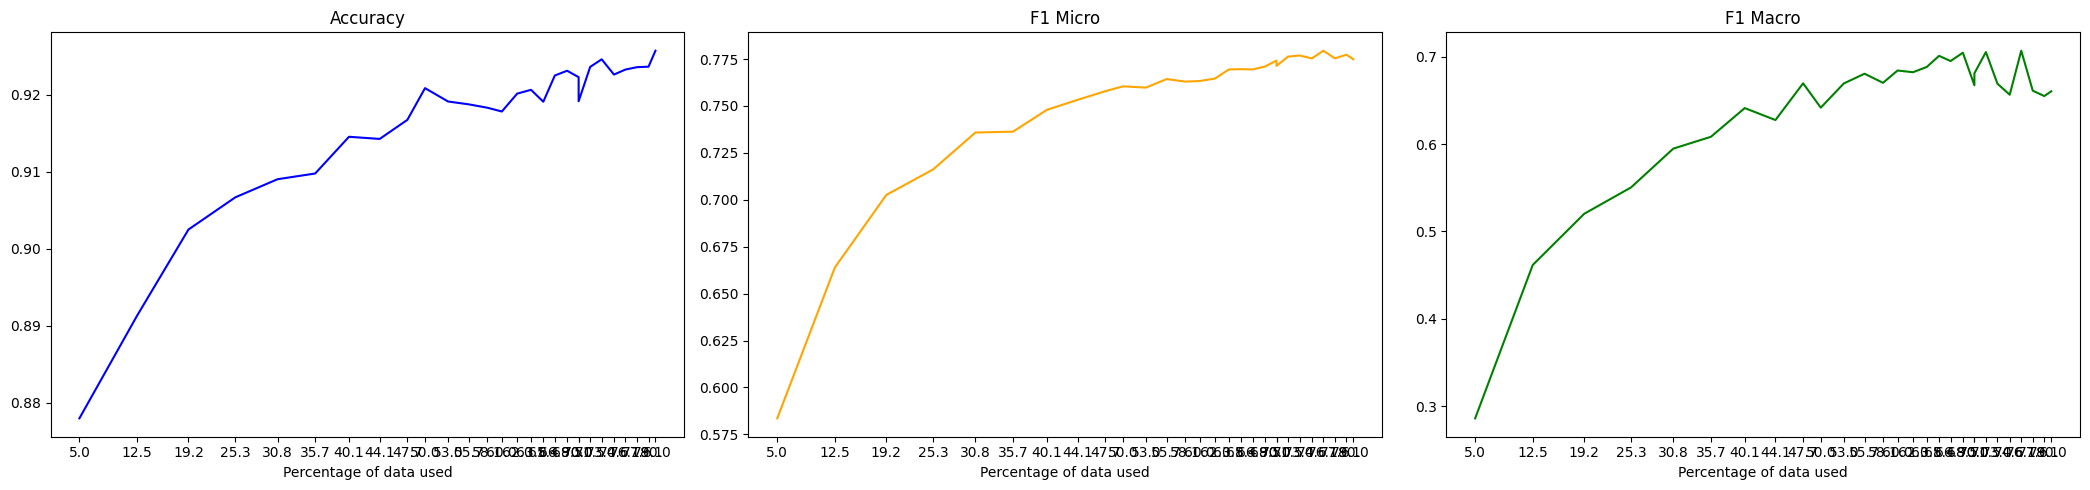

In [26]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6246, Accuracy: 0.8182, F1 Micro: 0.1799, F1 Macro: 0.0858
Epoch 2/10, Train Loss: 0.4638, Accuracy: 0.833, F1 Micro: 0.0996, F1 Macro: 0.0359
Epoch 3/10, Train Loss: 0.4095, Accuracy: 0.8315, F1 Micro: 0.0624, F1 Macro: 0.0249
Epoch 4/10, Train Loss: 0.4064, Accuracy: 0.8374, F1 Micro: 0.1245, F1 Macro: 0.0484
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3745, Accuracy: 0.8494, F1 Micro: 0.2754, F1 Macro: 0.0936
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3744, Accuracy: 0.8575, F1 Micro: 0.3823, F1 Macro: 0.1266
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.347, Accuracy: 0.8657, F1 Micro: 0.4875, F1 Macro: 0.2062
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.327, Accuracy: 0.8752, F1 Micro: 0.5421, F1 Macro: 0.2529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2895, Accuracy: 0.8767, F1 Micro: 0.5895, F1 Macro: 0.2828
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.532, Accuracy: 0.8317, F1 Micro: 0.0744, F1 Macro: 0.028
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4033, Accuracy: 0.8386, F1 Micro: 0.1451, F1 Macro: 0.0526
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3581, Accuracy: 0.8558, F1 Micro: 0.3645, F1 Macro: 0.1149
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3342, Accuracy: 0.8768, F1 Micro: 0.5723, F1 Macro: 0.2644
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2981, Accuracy: 0.8813, F1 Micro: 0.5774, F1 Macro: 0.2861
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2664, Accuracy: 0.8866, F1 Micro: 0.6295, F1 Macro: 0.3297
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.234, Accuracy: 0.8886, F1 Micro: 0.6608, F1 Macro: 0.3751
Epoch 8/10, Train Loss: 0.2217, Accuracy: 0.8922, F1 Micro: 0.646, F1 Macro: 0.3907
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1905, Accuracy: 0.8938, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4806, Accuracy: 0.8297, F1 Micro: 0.0252, F1 Macro: 0.011
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.366, Accuracy: 0.8559, F1 Micro: 0.3673, F1 Macro: 0.1187
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3213, Accuracy: 0.8748, F1 Micro: 0.6068, F1 Macro: 0.2914
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2831, Accuracy: 0.8853, F1 Micro: 0.6094, F1 Macro: 0.2997
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2465, Accuracy: 0.8902, F1 Micro: 0.6452, F1 Macro: 0.363
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2184, Accuracy: 0.8939, F1 Micro: 0.6838, F1 Macro: 0.4454
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1927, Accuracy: 0.8981, F1 Micro: 0.6839, F1 Macro: 0.4999
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1703, Accuracy: 0.8994, F1 Micro: 0.7009, F1 Macro: 0.5332
Epoch 9/10, Train Loss: 0.1522, Accuracy: 0.8994, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4588, Accuracy: 0.8458, F1 Micro: 0.2629, F1 Macro: 0.0892
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3544, Accuracy: 0.8775, F1 Micro: 0.5604, F1 Macro: 0.2565
Epoch 3/10, Train Loss: 0.2844, Accuracy: 0.8812, F1 Micro: 0.5541, F1 Macro: 0.273
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2493, Accuracy: 0.8958, F1 Micro: 0.6667, F1 Macro: 0.4427
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2185, Accuracy: 0.8986, F1 Micro: 0.6911, F1 Macro: 0.464
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1883, Accuracy: 0.9038, F1 Micro: 0.7041, F1 Macro: 0.5268
Epoch 7/10, Train Loss: 0.1591, Accuracy: 0.9043, F1 Micro: 0.6961, F1 Macro: 0.5417
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1397, Accuracy: 0.9067, F1 Micro: 0.7294, F1 Macro: 0.5571
Epoch 9/10, Train Loss: 0.1265, Accuracy: 0.9046, F1 Micro: 0.7055, F1 Macro: 0.4946
Epoch 10/10, Train Loss: 0.1107, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4527, Accuracy: 0.8336, F1 Micro: 0.0754, F1 Macro: 0.0306
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3382, Accuracy: 0.8788, F1 Micro: 0.6069, F1 Macro: 0.293
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2764, Accuracy: 0.8913, F1 Micro: 0.6455, F1 Macro: 0.3716
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2328, Accuracy: 0.899, F1 Micro: 0.6946, F1 Macro: 0.4942
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2027, Accuracy: 0.9009, F1 Micro: 0.7157, F1 Macro: 0.5355
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1697, Accuracy: 0.9059, F1 Micro: 0.7182, F1 Macro: 0.5389
Epoch 7/10, Train Loss: 0.1498, Accuracy: 0.9088, F1 Micro: 0.7129, F1 Macro: 0.5276
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1293, Accuracy: 0.9093, F1 Micro: 0.7289, F1 Macro: 0.5646
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1145, Accuracy: 0.9113, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4373, Accuracy: 0.8479, F1 Micro: 0.2624, F1 Macro: 0.0906
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.317, Accuracy: 0.8839, F1 Micro: 0.6149, F1 Macro: 0.307
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2551, Accuracy: 0.8952, F1 Micro: 0.6513, F1 Macro: 0.4174
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.224, Accuracy: 0.8993, F1 Micro: 0.6693, F1 Macro: 0.4258
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1944, Accuracy: 0.9049, F1 Micro: 0.7217, F1 Macro: 0.5194
Epoch 6/10, Train Loss: 0.1653, Accuracy: 0.9101, F1 Micro: 0.7182, F1 Macro: 0.5502
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1419, Accuracy: 0.9079, F1 Micro: 0.7239, F1 Macro: 0.5447
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.124, Accuracy: 0.911, F1 Micro: 0.7261, F1 Macro: 0.5802
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1057, Accuracy: 0.9145, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.429, Accuracy: 0.857, F1 Micro: 0.3588, F1 Macro: 0.1207
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3034, Accuracy: 0.8874, F1 Micro: 0.6418, F1 Macro: 0.3564
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2501, Accuracy: 0.9, F1 Micro: 0.6897, F1 Macro: 0.4826
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2134, Accuracy: 0.9036, F1 Micro: 0.7031, F1 Macro: 0.4903
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.184, Accuracy: 0.9084, F1 Micro: 0.731, F1 Macro: 0.5791
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1599, Accuracy: 0.9122, F1 Micro: 0.7359, F1 Macro: 0.5895
Epoch 7/10, Train Loss: 0.1316, Accuracy: 0.9127, F1 Micro: 0.7262, F1 Macro: 0.5751
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1153, Accuracy: 0.911, F1 Micro: 0.7447, F1 Macro: 0.6012
Epoch 9/10, Train Loss: 0.0985, Accuracy: 0.9146, F1 Micro: 0.7371, F1 Macro: 0.6108
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4248, Accuracy: 0.8604, F1 Micro: 0.3745, F1 Macro: 0.1431
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2955, Accuracy: 0.8889, F1 Micro: 0.6329, F1 Macro: 0.3399
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2419, Accuracy: 0.8998, F1 Micro: 0.7023, F1 Macro: 0.5125
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2058, Accuracy: 0.9077, F1 Micro: 0.7283, F1 Macro: 0.5709
Epoch 5/10, Train Loss: 0.1812, Accuracy: 0.9109, F1 Micro: 0.7204, F1 Macro: 0.5468
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.147, Accuracy: 0.9144, F1 Micro: 0.7386, F1 Macro: 0.5898
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.125, Accuracy: 0.9167, F1 Micro: 0.7532, F1 Macro: 0.6127
Epoch 8/10, Train Loss: 0.1068, Accuracy: 0.9156, F1 Micro: 0.7475, F1 Macro: 0.6252
Epoch 9/10, Train Loss: 0.0909, Accuracy: 0.9161, F1 Micro: 0.7497, F1 Macro: 0.6305
Epoch 10/10, Train Loss: 0.0796, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4151, Accuracy: 0.8728, F1 Micro: 0.5372, F1 Macro: 0.2366
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2882, Accuracy: 0.8932, F1 Micro: 0.6593, F1 Macro: 0.4121
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.237, Accuracy: 0.9036, F1 Micro: 0.7135, F1 Macro: 0.5445
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1953, Accuracy: 0.9119, F1 Micro: 0.7313, F1 Macro: 0.5695
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.168, Accuracy: 0.9131, F1 Micro: 0.7376, F1 Macro: 0.5678
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1423, Accuracy: 0.9152, F1 Micro: 0.7387, F1 Macro: 0.5899
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1225, Accuracy: 0.9169, F1 Micro: 0.7562, F1 Macro: 0.6215
Epoch 8/10, Train Loss: 0.101, Accuracy: 0.9171, F1 Micro: 0.7393, F1 Macro: 0.6168
Epoch 9/10, Train Loss: 0.0901, Accuracy: 0.9175, F1 Micro: 0.7506, F1 Macro: 0.6341
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4163, Accuracy: 0.8729, F1 Micro: 0.551, F1 Macro: 0.2437
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.29, Accuracy: 0.8921, F1 Micro: 0.6336, F1 Macro: 0.4485
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2403, Accuracy: 0.9024, F1 Micro: 0.7173, F1 Macro: 0.5358
Epoch 4/10, Train Loss: 0.2068, Accuracy: 0.908, F1 Micro: 0.6837, F1 Macro: 0.5284
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1716, Accuracy: 0.914, F1 Micro: 0.7442, F1 Macro: 0.5874
Epoch 6/10, Train Loss: 0.1439, Accuracy: 0.9104, F1 Micro: 0.7429, F1 Macro: 0.5861
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1226, Accuracy: 0.918, F1 Micro: 0.7565, F1 Macro: 0.6217
Epoch 8/10, Train Loss: 0.1055, Accuracy: 0.9185, F1 Micro: 0.7536, F1 Macro: 0.6268
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0883, Accuracy: 0.9191, F1 Micro: 0.7611, F1 Macro: 0.6403
Epoch 10/10, Train Loss: 0.0778, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4088, Accuracy: 0.8764, F1 Micro: 0.5563, F1 Macro: 0.2543
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2788, Accuracy: 0.8963, F1 Micro: 0.6825, F1 Macro: 0.476
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2341, Accuracy: 0.9085, F1 Micro: 0.7132, F1 Macro: 0.5135
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2014, Accuracy: 0.9102, F1 Micro: 0.7395, F1 Macro: 0.5738
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1669, Accuracy: 0.9106, F1 Micro: 0.747, F1 Macro: 0.5829
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1386, Accuracy: 0.9191, F1 Micro: 0.7515, F1 Macro: 0.6121
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1194, Accuracy: 0.9182, F1 Micro: 0.762, F1 Macro: 0.633
Epoch 8/10, Train Loss: 0.1006, Accuracy: 0.9205, F1 Micro: 0.7619, F1 Macro: 0.661
Epoch 9/10, Train Loss: 0.0884, Accuracy: 0.9181, F1 Micro: 0.7612, F1 Macro: 0.6762
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3983, Accuracy: 0.8785, F1 Micro: 0.5856, F1 Macro: 0.2825
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2777, Accuracy: 0.8936, F1 Micro: 0.6247, F1 Macro: 0.3805
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2264, Accuracy: 0.9082, F1 Micro: 0.707, F1 Macro: 0.4929
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1923, Accuracy: 0.9145, F1 Micro: 0.7494, F1 Macro: 0.5898
Epoch 5/10, Train Loss: 0.1612, Accuracy: 0.9129, F1 Micro: 0.7473, F1 Macro: 0.5761
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1376, Accuracy: 0.9174, F1 Micro: 0.7507, F1 Macro: 0.5966
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1162, Accuracy: 0.9202, F1 Micro: 0.7571, F1 Macro: 0.6367
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0947, Accuracy: 0.9208, F1 Micro: 0.7664, F1 Macro: 0.6659
Epoch 9/10, Train Loss: 0.0805, Accuracy: 0.9121, F1 Micro: 0.7584, F1 Macro: 0.6712
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4009, Accuracy: 0.8785, F1 Micro: 0.5897, F1 Macro: 0.275
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2704, Accuracy: 0.8979, F1 Micro: 0.6965, F1 Macro: 0.5028
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2197, Accuracy: 0.9025, F1 Micro: 0.7256, F1 Macro: 0.5373
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.187, Accuracy: 0.9145, F1 Micro: 0.7433, F1 Macro: 0.5797
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1641, Accuracy: 0.9137, F1 Micro: 0.7476, F1 Macro: 0.5755
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1369, Accuracy: 0.9172, F1 Micro: 0.7589, F1 Macro: 0.6216
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1178, Accuracy: 0.9202, F1 Micro: 0.7607, F1 Macro: 0.6436
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.098, Accuracy: 0.9213, F1 Micro: 0.7633, F1 Macro: 0.659
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3946, Accuracy: 0.8784, F1 Micro: 0.5964, F1 Macro: 0.278
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2693, Accuracy: 0.8973, F1 Micro: 0.6942, F1 Macro: 0.4919
Epoch 3/10, Train Loss: 0.2273, Accuracy: 0.9069, F1 Micro: 0.6925, F1 Macro: 0.48
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1891, Accuracy: 0.9171, F1 Micro: 0.7447, F1 Macro: 0.5859
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1589, Accuracy: 0.9193, F1 Micro: 0.7506, F1 Macro: 0.5829
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1341, Accuracy: 0.9197, F1 Micro: 0.7602, F1 Macro: 0.6266
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1146, Accuracy: 0.9209, F1 Micro: 0.7619, F1 Macro: 0.6425
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0957, Accuracy: 0.921, F1 Micro: 0.767, F1 Macro: 0.6377
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0807, Accuracy: 0.9209, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3961, Accuracy: 0.878, F1 Micro: 0.574, F1 Macro: 0.2796
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2694, Accuracy: 0.9004, F1 Micro: 0.6891, F1 Macro: 0.5023
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2212, Accuracy: 0.9112, F1 Micro: 0.729, F1 Macro: 0.5521
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1893, Accuracy: 0.9134, F1 Micro: 0.7402, F1 Macro: 0.5846
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1551, Accuracy: 0.9166, F1 Micro: 0.7552, F1 Macro: 0.611
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1341, Accuracy: 0.9153, F1 Micro: 0.7635, F1 Macro: 0.6344
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1116, Accuracy: 0.921, F1 Micro: 0.7683, F1 Macro: 0.6404
Epoch 8/10, Train Loss: 0.095, Accuracy: 0.9207, F1 Micro: 0.7617, F1 Macro: 0.6516
Epoch 9/10, Train Loss: 0.0801, Accuracy: 0.921, F1 Micro: 0.7656, F1 Macro: 0.6663
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3862, Accuracy: 0.8799, F1 Micro: 0.6171, F1 Macro: 0.3097
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2618, Accuracy: 0.9021, F1 Micro: 0.6954, F1 Macro: 0.5032
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2143, Accuracy: 0.9109, F1 Micro: 0.721, F1 Macro: 0.5292
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1813, Accuracy: 0.9166, F1 Micro: 0.7514, F1 Macro: 0.5918
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1553, Accuracy: 0.919, F1 Micro: 0.7591, F1 Macro: 0.62
Epoch 6/10, Train Loss: 0.1282, Accuracy: 0.9154, F1 Micro: 0.7556, F1 Macro: 0.6274
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1106, Accuracy: 0.9202, F1 Micro: 0.763, F1 Macro: 0.6628
Epoch 8/10, Train Loss: 0.0916, Accuracy: 0.919, F1 Micro: 0.7581, F1 Macro: 0.6586
Epoch 9/10, Train Loss: 0.079, Accuracy: 0.9195, F1 Micro: 0.7621, F1 Macro: 0.6722
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3907, Accuracy: 0.8813, F1 Micro: 0.6092, F1 Macro: 0.3091
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2601, Accuracy: 0.9013, F1 Micro: 0.7087, F1 Macro: 0.5132
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.213, Accuracy: 0.9122, F1 Micro: 0.7214, F1 Macro: 0.5464
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1827, Accuracy: 0.9155, F1 Micro: 0.7472, F1 Macro: 0.6055
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.157, Accuracy: 0.9178, F1 Micro: 0.7544, F1 Macro: 0.6058
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1273, Accuracy: 0.92, F1 Micro: 0.7586, F1 Macro: 0.6235
Epoch 7/10, Train Loss: 0.1048, Accuracy: 0.9228, F1 Micro: 0.7577, F1 Macro: 0.6393
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0901, Accuracy: 0.9195, F1 Micro: 0.7655, F1 Macro: 0.6615
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0797, Accuracy: 0.9187, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3846, Accuracy: 0.8807, F1 Micro: 0.5653, F1 Macro: 0.269
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2613, Accuracy: 0.898, F1 Micro: 0.7026, F1 Macro: 0.4706
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.213, Accuracy: 0.9108, F1 Micro: 0.7367, F1 Macro: 0.5666
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1811, Accuracy: 0.918, F1 Micro: 0.7496, F1 Macro: 0.602
Epoch 5/10, Train Loss: 0.1503, Accuracy: 0.9168, F1 Micro: 0.7444, F1 Macro: 0.5847
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1291, Accuracy: 0.9202, F1 Micro: 0.7623, F1 Macro: 0.62
Epoch 7/10, Train Loss: 0.1062, Accuracy: 0.9214, F1 Micro: 0.76, F1 Macro: 0.6388
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0919, Accuracy: 0.9224, F1 Micro: 0.7731, F1 Macro: 0.6696
Epoch 9/10, Train Loss: 0.0786, Accuracy: 0.9214, F1 Micro: 0.7694, F1 Macro: 0.6595
Epoch 10/10, Train Loss: 0.0697, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3803, Accuracy: 0.8832, F1 Micro: 0.6301, F1 Macro: 0.334
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2627, Accuracy: 0.9046, F1 Micro: 0.6887, F1 Macro: 0.4924
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2134, Accuracy: 0.9126, F1 Micro: 0.7426, F1 Macro: 0.5818
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1793, Accuracy: 0.9182, F1 Micro: 0.7585, F1 Macro: 0.596
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1514, Accuracy: 0.9214, F1 Micro: 0.7615, F1 Macro: 0.6186
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1237, Accuracy: 0.9176, F1 Micro: 0.7643, F1 Macro: 0.6455
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1089, Accuracy: 0.9233, F1 Micro: 0.7712, F1 Macro: 0.6704
Epoch 8/10, Train Loss: 0.091, Accuracy: 0.9194, F1 Micro: 0.7651, F1 Macro: 0.6776
Epoch 9/10, Train Loss: 0.0768, Accuracy: 0.9201, F1 Micro: 0.7675, F1 Macro: 0.6791
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3842, Accuracy: 0.8835, F1 Micro: 0.5716, F1 Macro: 0.2828
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.259, Accuracy: 0.8989, F1 Micro: 0.669, F1 Macro: 0.3601
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2098, Accuracy: 0.9145, F1 Micro: 0.7475, F1 Macro: 0.5895
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1759, Accuracy: 0.9168, F1 Micro: 0.7554, F1 Macro: 0.6029
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1518, Accuracy: 0.9183, F1 Micro: 0.7591, F1 Macro: 0.6253
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1241, Accuracy: 0.9194, F1 Micro: 0.7711, F1 Macro: 0.6681
Epoch 7/10, Train Loss: 0.1086, Accuracy: 0.9203, F1 Micro: 0.7634, F1 Macro: 0.6621
Epoch 8/10, Train Loss: 0.089, Accuracy: 0.9235, F1 Micro: 0.7673, F1 Macro: 0.6628
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0778, Accuracy: 0.9239, F1 Micro: 0.7769, F1 Macro: 0.6938
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3819, Accuracy: 0.8828, F1 Micro: 0.572, F1 Macro: 0.2816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2576, Accuracy: 0.9058, F1 Micro: 0.7097, F1 Macro: 0.5143
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2136, Accuracy: 0.9134, F1 Micro: 0.74, F1 Macro: 0.5502
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1802, Accuracy: 0.9179, F1 Micro: 0.7583, F1 Macro: 0.611
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1482, Accuracy: 0.9214, F1 Micro: 0.7592, F1 Macro: 0.6071
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1251, Accuracy: 0.9217, F1 Micro: 0.7635, F1 Macro: 0.6226
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1072, Accuracy: 0.9217, F1 Micro: 0.7734, F1 Macro: 0.6705
Epoch 8/10, Train Loss: 0.0902, Accuracy: 0.9239, F1 Micro: 0.7693, F1 Macro: 0.6772
Epoch 9/10, Train Loss: 0.0755, Accuracy: 0.9243, F1 Micro: 0.7718, F1 Macro: 0.6826
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3883, Accuracy: 0.8826, F1 Micro: 0.5829, F1 Macro: 0.2865
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2566, Accuracy: 0.9048, F1 Micro: 0.7049, F1 Macro: 0.5107
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2076, Accuracy: 0.9137, F1 Micro: 0.7434, F1 Macro: 0.5611
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1772, Accuracy: 0.9183, F1 Micro: 0.7598, F1 Macro: 0.602
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.147, Accuracy: 0.9199, F1 Micro: 0.7599, F1 Macro: 0.628
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1223, Accuracy: 0.9197, F1 Micro: 0.7683, F1 Macro: 0.6405
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1047, Accuracy: 0.923, F1 Micro: 0.7718, F1 Macro: 0.6615
Epoch 8/10, Train Loss: 0.0844, Accuracy: 0.9207, F1 Micro: 0.771, F1 Macro: 0.6799
Epoch 9/10, Train Loss: 0.0747, Accuracy: 0.9196, F1 Micro: 0.7703, F1 Macro: 0.6768
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3774, Accuracy: 0.8843, F1 Micro: 0.574, F1 Macro: 0.2849
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2495, Accuracy: 0.9075, F1 Micro: 0.7058, F1 Macro: 0.5111
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2066, Accuracy: 0.9109, F1 Micro: 0.7422, F1 Macro: 0.5695
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1727, Accuracy: 0.9199, F1 Micro: 0.7609, F1 Macro: 0.608
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1474, Accuracy: 0.9207, F1 Micro: 0.7693, F1 Macro: 0.642
Epoch 6/10, Train Loss: 0.1209, Accuracy: 0.9209, F1 Micro: 0.7686, F1 Macro: 0.639
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1008, Accuracy: 0.9227, F1 Micro: 0.7726, F1 Macro: 0.6765
Epoch 8/10, Train Loss: 0.085, Accuracy: 0.9209, F1 Micro: 0.7615, F1 Macro: 0.6792
Epoch 9/10, Train Loss: 0.0717, Accuracy: 0.9219, F1 Micro: 0.766, F1 Macro: 0.6771
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3803, Accuracy: 0.8853, F1 Micro: 0.591, F1 Macro: 0.2949
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2553, Accuracy: 0.9058, F1 Micro: 0.7003, F1 Macro: 0.4728
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2115, Accuracy: 0.9133, F1 Micro: 0.7428, F1 Macro: 0.5595
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1764, Accuracy: 0.9184, F1 Micro: 0.7639, F1 Macro: 0.6118
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1406, Accuracy: 0.9218, F1 Micro: 0.7702, F1 Macro: 0.6419
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1217, Accuracy: 0.9224, F1 Micro: 0.7721, F1 Macro: 0.6453
Epoch 7/10, Train Loss: 0.1025, Accuracy: 0.9212, F1 Micro: 0.7697, F1 Macro: 0.6431
Epoch 8/10, Train Loss: 0.0885, Accuracy: 0.9166, F1 Micro: 0.7686, F1 Macro: 0.6779
Epoch 9/10, Train Loss: 0.0729, Accuracy: 0.9188, F1 Micro: 0.7679, F1 Macro: 0.6872
Epoch 10/10, Train Loss: 0.0629, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3773, Accuracy: 0.8866, F1 Micro: 0.6268, F1 Macro: 0.3479
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2535, Accuracy: 0.9059, F1 Micro: 0.7156, F1 Macro: 0.5458
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2071, Accuracy: 0.9158, F1 Micro: 0.7421, F1 Macro: 0.5645
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.172, Accuracy: 0.9208, F1 Micro: 0.753, F1 Macro: 0.608
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.149, Accuracy: 0.9213, F1 Micro: 0.7734, F1 Macro: 0.6463
Epoch 6/10, Train Loss: 0.1223, Accuracy: 0.9231, F1 Micro: 0.7699, F1 Macro: 0.6575
Epoch 7/10, Train Loss: 0.1024, Accuracy: 0.9193, F1 Micro: 0.7697, F1 Macro: 0.6573
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0843, Accuracy: 0.9242, F1 Micro: 0.7779, F1 Macro: 0.6915
Epoch 9/10, Train Loss: 0.0723, Accuracy: 0.9228, F1 Micro: 0.7716, F1 Macro: 0.679
Epoch 10/10, Train Loss: 0.0644, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3736, Accuracy: 0.8858, F1 Micro: 0.6115, F1 Macro: 0.3147
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2492, Accuracy: 0.9073, F1 Micro: 0.7124, F1 Macro: 0.5265
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2036, Accuracy: 0.9145, F1 Micro: 0.7465, F1 Macro: 0.5762
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1712, Accuracy: 0.9198, F1 Micro: 0.7629, F1 Macro: 0.6051
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1393, Accuracy: 0.9207, F1 Micro: 0.7635, F1 Macro: 0.6427
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1217, Accuracy: 0.9228, F1 Micro: 0.7729, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0996, Accuracy: 0.9231, F1 Micro: 0.7742, F1 Macro: 0.6732
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0837, Accuracy: 0.9235, F1 Micro: 0.7755, F1 Macro: 0.6925
Epoch 9/10, Train Loss: 0.0735, Accuracy: 0.9213, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3709, Accuracy: 0.8892, F1 Micro: 0.6296, F1 Macro: 0.3197
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2475, Accuracy: 0.9077, F1 Micro: 0.7132, F1 Macro: 0.5265
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1989, Accuracy: 0.9163, F1 Micro: 0.752, F1 Macro: 0.584
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1726, Accuracy: 0.9209, F1 Micro: 0.7628, F1 Macro: 0.617
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1442, Accuracy: 0.9255, F1 Micro: 0.7737, F1 Macro: 0.6481
Epoch 6/10, Train Loss: 0.1195, Accuracy: 0.9245, F1 Micro: 0.7684, F1 Macro: 0.6333
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1001, Accuracy: 0.9238, F1 Micro: 0.7783, F1 Macro: 0.682
Epoch 8/10, Train Loss: 0.084, Accuracy: 0.9246, F1 Micro: 0.7763, F1 Macro: 0.6919
Epoch 9/10, Train Loss: 0.0713, Accuracy: 0.9223, F1 Micro: 0.7749, F1 Macro: 0.694
Epoch 10/10, Train Loss: 0.0629, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3714, Accuracy: 0.8885, F1 Micro: 0.6249, F1 Macro: 0.3374
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2512, Accuracy: 0.9016, F1 Micro: 0.7257, F1 Macro: 0.5341
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2052, Accuracy: 0.9157, F1 Micro: 0.7508, F1 Macro: 0.5942
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.17, Accuracy: 0.9224, F1 Micro: 0.7585, F1 Macro: 0.6046
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.142, Accuracy: 0.9208, F1 Micro: 0.7731, F1 Macro: 0.6485
Epoch 6/10, Train Loss: 0.1197, Accuracy: 0.9229, F1 Micro: 0.7731, F1 Macro: 0.6504
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0993, Accuracy: 0.9234, F1 Micro: 0.7736, F1 Macro: 0.6708
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0858, Accuracy: 0.9225, F1 Micro: 0.7792, F1 Macro: 0.7035
Epoch 9/10, Train Loss: 0.0731, Accuracy: 0.9239, F1 Micro: 0.7746, F1 Macro: 0.7004
Epoch 1

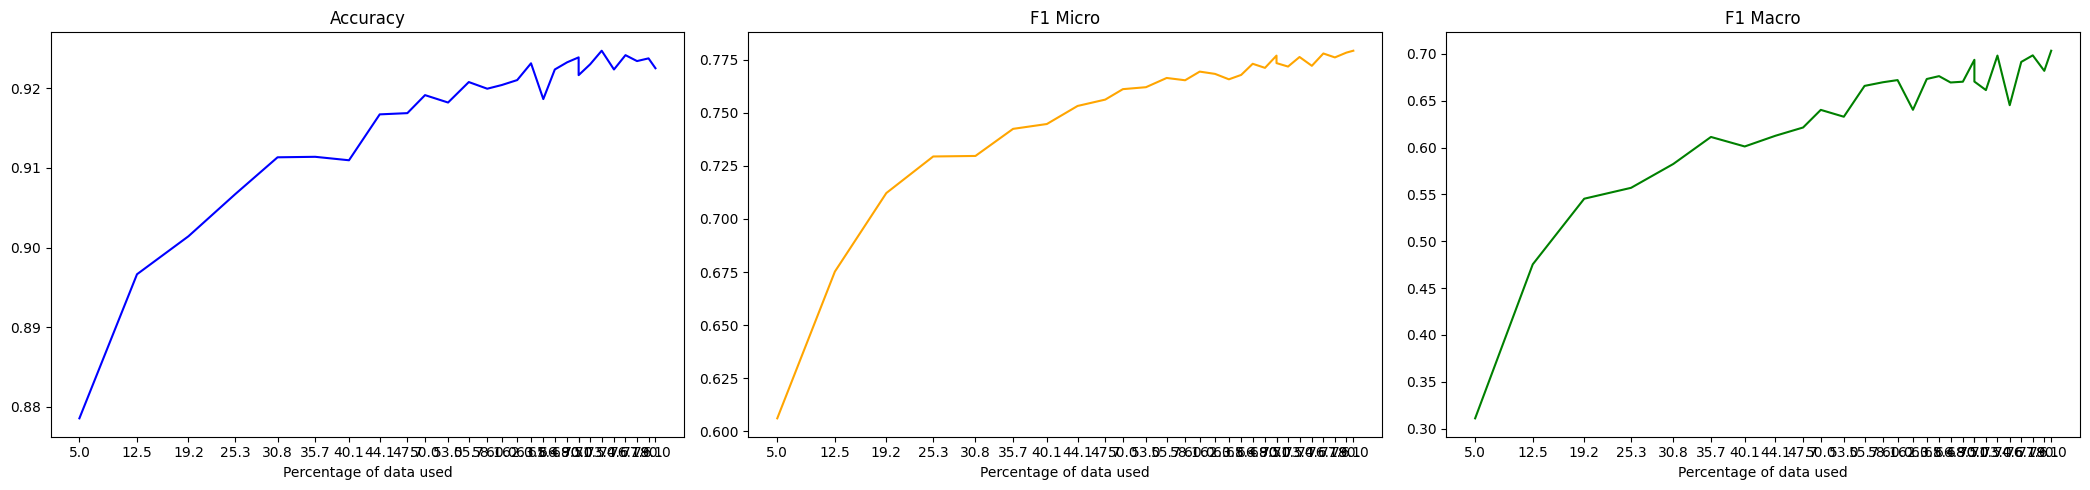

In [ ]:
active_learning(seeds[4], 4)